## Morhunenko Mykola. Fourth variant. "Peninsula" region
`descriptive` file was taken as a template

In [1]:
import numpy as np
import pandas as pd
import matplotlib
from datetime import datetime
import matplotlib.pyplot as plt
import pyflux as pf
import statsmodels as ss
import statsmodels.api as sm
import seaborn as sns
import sys
import warnings
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as smt
from sklearn.metrics import mean_squared_error as mse
from fbprophet import Prophet
from xgboost import XGBRegressor
from pandas import to_datetime
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, RepeatVector
from keras.layers import LSTM
from keras.optimizers import Adam, Adagrad
from hyperas import optim
from hyperas.distributions import choice, uniform
from hyperopt import Trials, STATUS_OK, tpe, rand

%matplotlib inline
matplotlib.rcParams['figure.dpi']= 100
matplotlib.rcParams['figure.figsize'] = 15, 5

In [2]:
REGIONS = [['JH', 'Johor', 'JH'], 
           ['PH', 'Pahang', 'PH'],
           ['PRK', 'Perak', 'PRK'], 
           ['OtherPEN', 'Other Pen. States', 'OtherPEN'],
           ['PEN', 'Peninsula', 'Pmalay'],
           ['SBH', 'Sabah', 'SBH'],
           ['SWK', 'Sarawak', 'SWK']]

In [3]:
production = pd.read_csv('data/production_good.csv')
rainfall = pd.read_csv('data/rainfall_good.csv')
area = pd.read_csv('data/area_good.csv')

In [4]:
RAINFALL_LAGS = [6, 7, 8, 9, 10, 11, 12]
PRODUCTION_LAGS = [6, 7, 8, 9, 10, 11, 12]

In [5]:
def process_data(production, rainfall, area, REGIONS, PRODUCTION_LAGS, RAINFALL_LAGS):
    output = {}
    for i, region in enumerate(REGIONS):
        data = production[production.Region == region[0]]
        data = pd.merge(data[['Year', 'Month', 'Production', 'Diff_production']],
                        rainfall[rainfall.Region == region[1]][['Year', 'Month', 'Rainfall']], 
                        on=['Year', 'Month'], how='left')

        data = pd.merge(data, area[area.Region == region[2]][
            ['Year', 'Area_ma', 'Area_npa', 'Area_rpa', 'Area_New', 'Area_ma_new']], on='Year', how='left')
            
        data['Year'] = data['Year'].astype(int)
        data['Month'] = data['Month'].astype(int)
        data.reset_index(inplace=True)

        data.set_index([pd.to_datetime(['{0}-{1}-01'.format(x, y) for (x, y) in zip(data.Year, data.Month)])],
                       inplace=True)

        data.drop(['index', 'Year', 'Area_New', 'Diff_production'], axis=1, inplace=True)
        data['Time'] = np.arange(len(data))

        for lag in RAINFALL_LAGS:
            temp = np.concatenate((np.array([np.nan for _ in range(lag)]), data.Rainfall.values[:-lag]))
            data['Rainfall_{0}'.format(lag)] = temp

        for lag in PRODUCTION_LAGS:
            temp = np.concatenate((np.array([np.nan for _ in range(lag)]), data.Production.values[:-lag]))
            data['Production_{0}'.format(lag)] = temp
        
        PRODUCTION = data.Production
        data.drop(['Production'], axis=1, inplace=True)

        data.fillna(data.mean(), inplace=True)

        #  And finally drop rainfalls
        data.drop(['Rainfall'], axis=1, inplace=True)
        ### HERE I CAN ADD FEATURE ENGINEERING!!!

        #  And clip first year
        for col in data.columns:
            data['_'.join([region[1], str(col)])] = data[col]
            data.drop([col], axis=1, inplace=True)
        
        output[region[1]] = (data[max(PRODUCTION_LAGS):], PRODUCTION[max(PRODUCTION_LAGS):])
    return output


In [6]:
DATA = process_data(production, rainfall, area, REGIONS, PRODUCTION_LAGS, RAINFALL_LAGS)

In [7]:
DATA.keys()

dict_keys(['Johor', 'Pahang', 'Perak', 'Other Pen. States', 'Peninsula', 'Sabah', 'Sarawak'])

In [8]:
DATA=DATA['Peninsula']

In [9]:
time = np.arange(len(DATA[1]))

#### Stationarity
Time-series property that indicates that the chosen Time Series has constant mean, variance, autocorrelation structure and have no periodic components over time. To get a stationary time series, we can split it into components (trend, seasonality and residuals) and take that residual. Thay can be stationary, but to be sure, we have to test it (for example, use Augmented Dickey-Fuller test).
#### Differencing
One more method to make a series stationary. If we have lagged data and can see autocorrelations in it, we can subtract from our series the same series, but lagged by one. More simple: from every element $E_{t}$ subtract $E_{t-1}$
#### Moving Average, Exponential Smoothing
Both - techniques to extract useful patterns from the series. 
Moving average - we chose a window and simply slide over the series with that window and calculate average. Can be used to find a trend, seasonality and a little bit of noise.
Exponential Smoothing - when our weights in the observation history are different. For example, nearest data have a bigger impact than older

# Additive VS multiplicative

<AxesSubplot:>

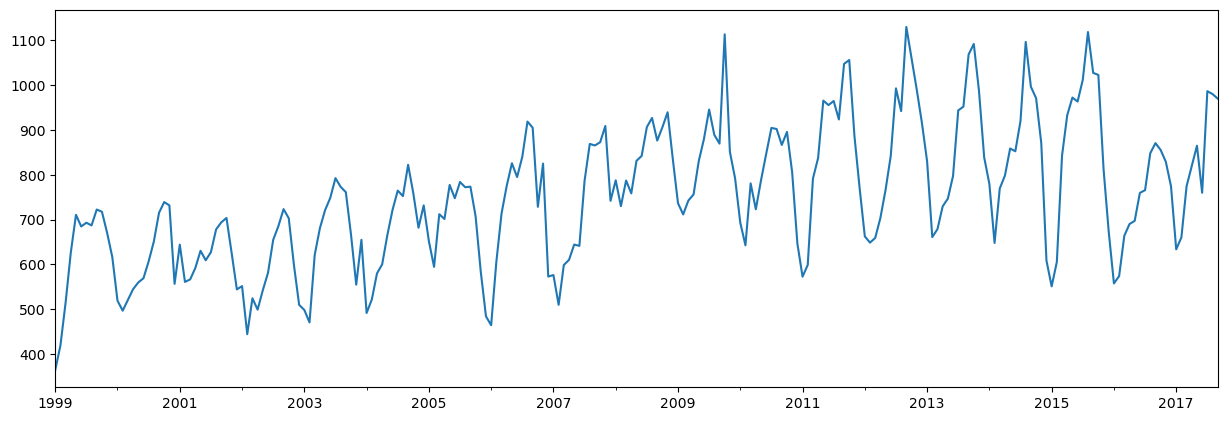

In [10]:
DATA[1].plot(figsize=(15,5))

### Additive 

We have a time series, that can be either additive ot multiplicative. This cpecific looks like additive, but the task is to make all on both data. Firstle, let's split the series on the trend, seasonality and residuals. As far as we have monthly data, period have to be 12. 

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

ss_decomposition = seasonal_decompose(x=DATA[1], model='additive', period=12)
estimated_trend_add = ss_decomposition.trend
estimated_seasonal_add = ss_decomposition.seasonal
estimated_residual_add = ss_decomposition.resid

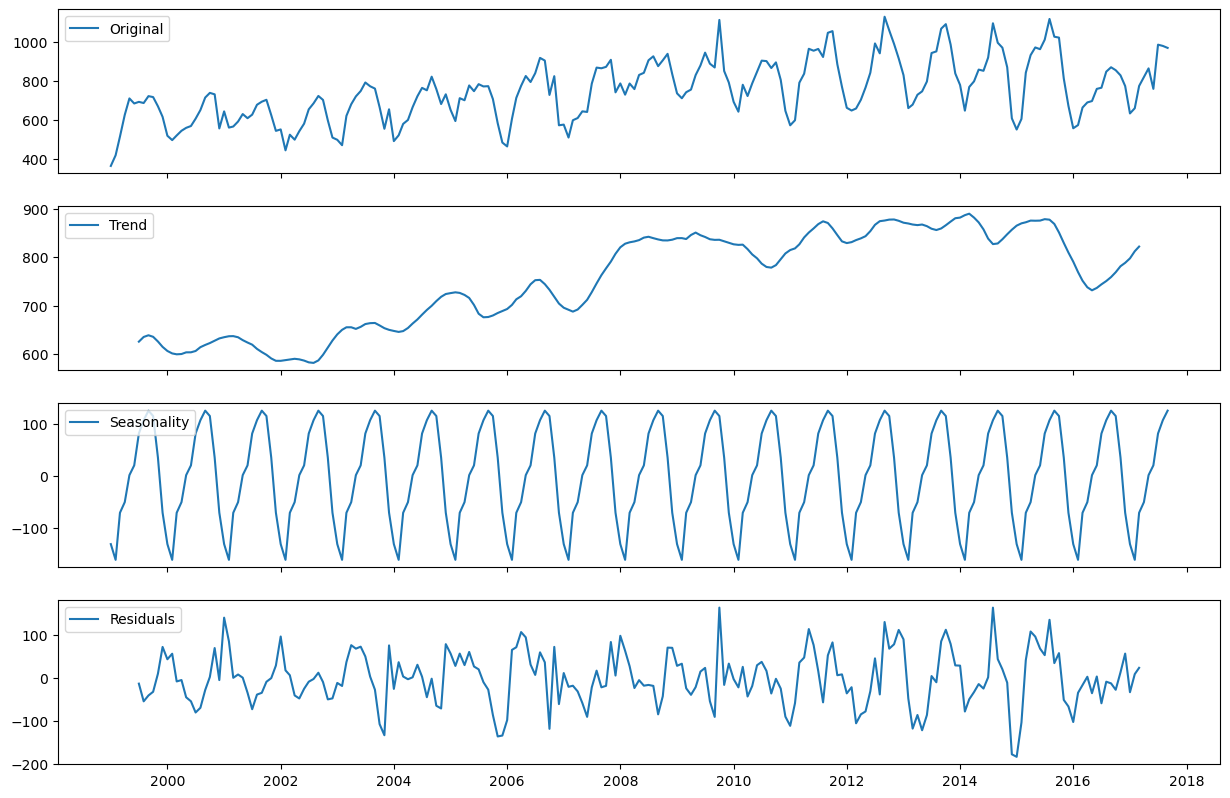

In [12]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0].plot(DATA[1], label='Original')
axes[0].legend(loc='upper left');

axes[1].plot(estimated_trend_add, label='Trend')
axes[1].legend(loc='upper left');

axes[2].plot(estimated_seasonal_add, label='Seasonality')
axes[2].legend(loc='upper left');

axes[3].plot(estimated_residual_add, label='Residuals')
axes[3].legend(loc='upper left');

In [13]:
estimated_residual_add = estimated_residual_add.dropna()

In [14]:
estimated_residual_add

1999-07-01   -13.195076
1999-08-01   -54.318465
1999-09-01   -40.678572
1999-10-01   -32.108988
1999-11-01     9.923859
                ...    
2016-11-01    13.234901
2016-12-01    56.659023
2017-01-01   -33.127078
2017-02-01     8.965764
2017-03-01    23.533044
Name: resid, Length: 213, dtype: float64

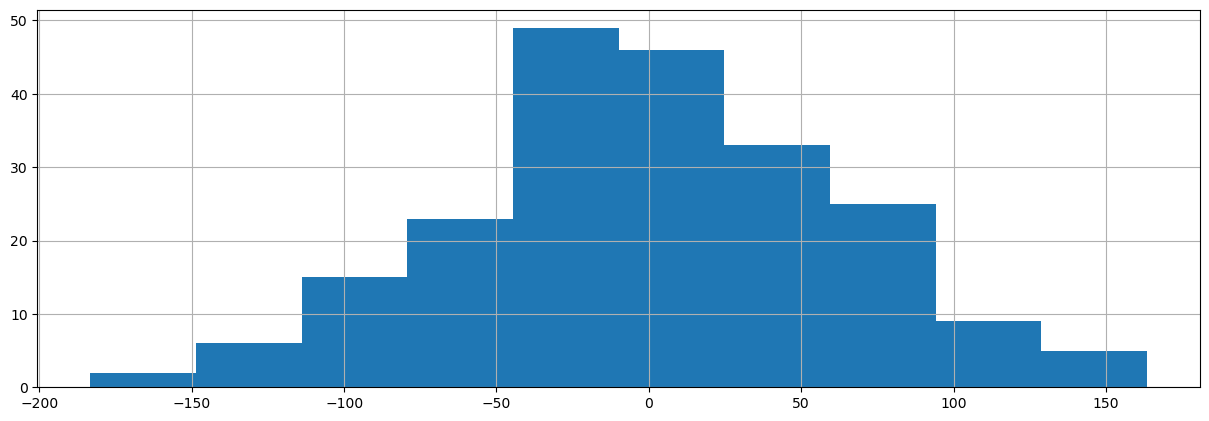

In [15]:
pd.Series(estimated_residual_add).hist();

### Multiplicative

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose

ss_decomposition = seasonal_decompose(x=DATA[1], model='multiplicative', period=12)
estimated_trend_mul = ss_decomposition.trend
estimated_seasonal_mul = ss_decomposition.seasonal
estimated_residual_mul = ss_decomposition.resid

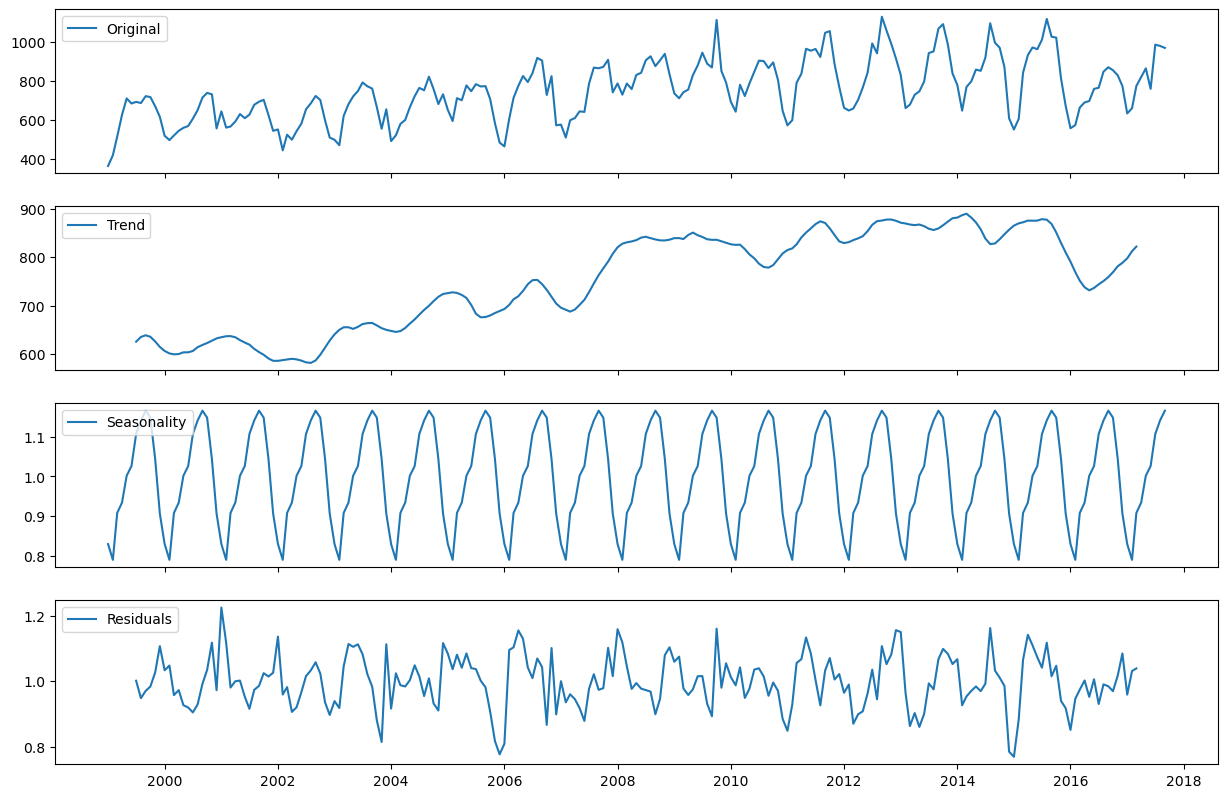

In [17]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0].plot(DATA[1], label='Original')
axes[0].legend(loc='upper left');

axes[1].plot(estimated_trend_mul, label='Trend')
axes[1].legend(loc='upper left');

axes[2].plot(estimated_seasonal_mul, label='Seasonality')
axes[2].legend(loc='upper left');

axes[3].plot(estimated_residual_mul, label='Residuals')
axes[3].legend(loc='upper left');

In [18]:
estimated_residual_mul = estimated_residual_mul.dropna()


In [19]:
estimated_residual_mul

1999-07-01    1.001068
1999-08-01    0.947909
1999-09-01    0.970295
1999-10-01    0.983422
1999-11-01    1.026705
                ...   
2016-11-01    1.017131
2016-12-01    1.084467
2017-01-01    0.958693
2017-02-01    1.030624
2017-03-01    1.038703
Name: resid, Length: 213, dtype: float64

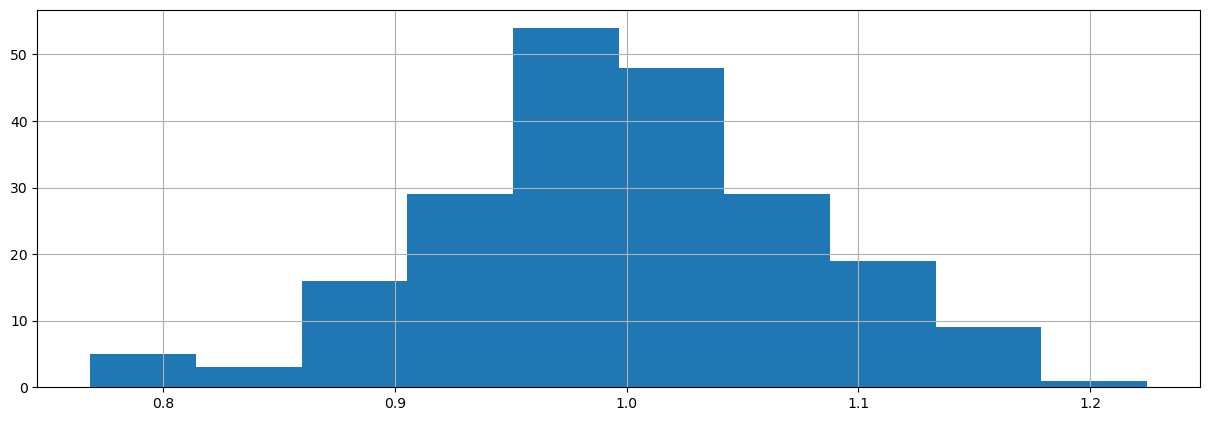

In [20]:
pd.Series(estimated_residual_mul).hist();

In [21]:
adf_add, pvalue_add, usedlag_add, nobs_add, critical_values_add, icbest_add = adfuller(estimated_residual_add)
adf_mul, pvalue_mul, usedlag_mul, nobs_mul, critical_values_mul, icbest_mul = adfuller(estimated_residual_mul)

In [22]:
print(adf_add, adf_mul)

-7.611191669118278 -7.465135160119531


In [23]:
print(pvalue_add, pvalue_mul)

2.252834213113104e-11 5.2286263171231255e-11


In [24]:
print(critical_values_add, "\n",critical_values_mul)

{'1%': -3.4638151713286316, '5%': -2.876250632135043, '10%': -2.574611347821651} 
 {'1%': -3.463476079125, '5%': -2.876102355, '10%': -2.574532225}


using that p-values, we can decide, which model is better to choose, but let's continue with both

## Remove autocorelation with differencing


One more way to get stationary series is to aplly difference method. it can be applied to a lagged data, and here we have such data.

In [25]:
difference = DATA[1] - DATA[1].shift(1)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [26]:
estimated_residual_dif = pd.Series(difference, index=DATA[1][1:].index)

<AxesSubplot:>

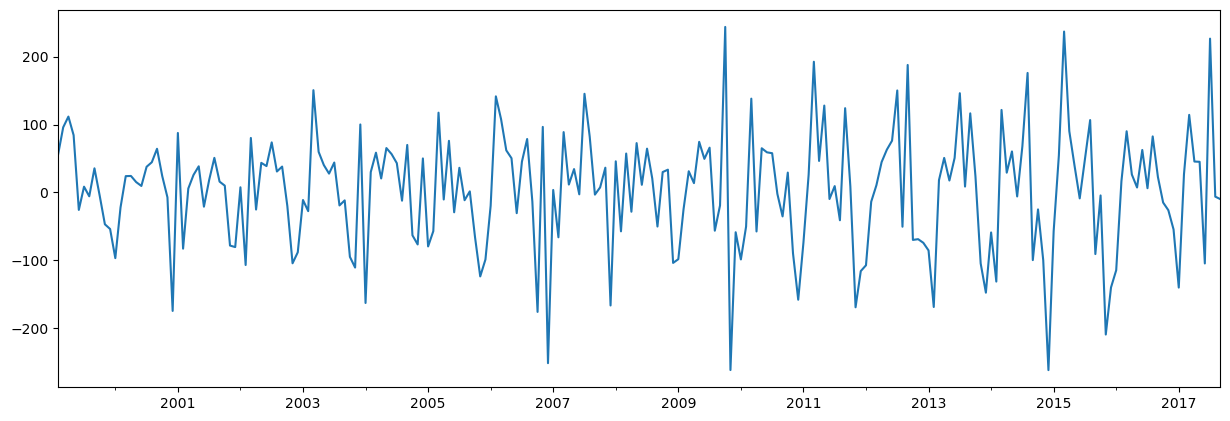

In [27]:
# plt.plot(np.arange(len(difference)), difference)
estimated_residual_dif.plot()

In [28]:
adf_dif, pvalue_dif, usedlag_dif, nobs_dif, critical_values_dif, icbest_dif = adfuller(estimated_residual_dif)

In [29]:
print(adf_dif)

-6.07961807749893


In [30]:
print(pvalue_dif)

1.1002117264342182e-07


In [31]:
print(critical_values_dif)

{'1%': -3.4620315036789666, '5%': -2.8754705024827127, '10%': -2.5741950726860647}


now if we compare pvalues of decomposition and differencing methods, it is better to take the assumption that the series is additive and use decomposition. but for now we have three series: estimated_residual_add, estimated_residual_dif, estimated_residual_mul and will work with all of them

# Moving Average, Exponential Smoothing

### Mooving Average

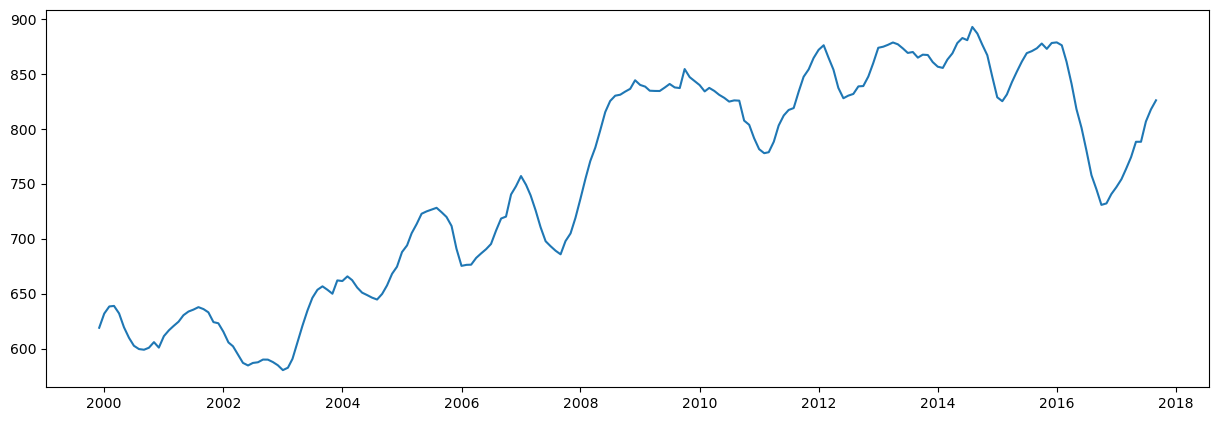

In [32]:
DATASET = [estimated_residual_add, estimated_residual_mul, estimated_residual_dif]

ts_moving_avg_right = DATA[1].rolling(12, center=False).mean()
plt.plot(ts_moving_avg_right)

Let's get our stationary series, residuals, using MA result

<AxesSubplot:>

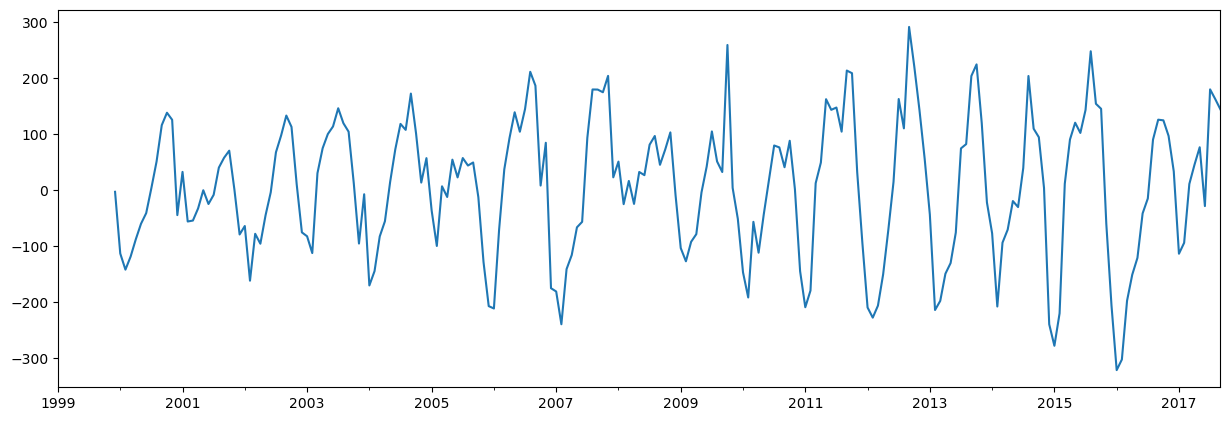

In [33]:
ts_ma_diff = DATA[1] - ts_moving_avg_right
ts_ma_diff.plot()

In [34]:
DATASET.append(ts_ma_diff.dropna())

In [35]:
def stationarity_test(ts):
    # only now I found the stationarity test in the template file, so I will use it
    
    rolmean = ts.rolling(12).mean()
    rolstd = ts.rolling(12).std()

    orig = plt.plot(ts, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    # Dickey-Fuller test:
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(ts, autolag='AIC')
    print(dftest)     
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

Results of Dickey-Fuller Test:
(-6.322120482471278, 3.04806302559622e-08, 13, 200, {'1%': -3.463476079125, '5%': -2.876102355, '10%': -2.574532225}, 2197.41471492452)
Test Statistic                -6.322120e+00
p-value                        3.048063e-08
#Lags Used                     1.300000e+01
Number of Observations Used    2.000000e+02
Critical Value (1%)           -3.463476e+00
Critical Value (5%)           -2.876102e+00
Critical Value (10%)          -2.574532e+00
dtype: float64


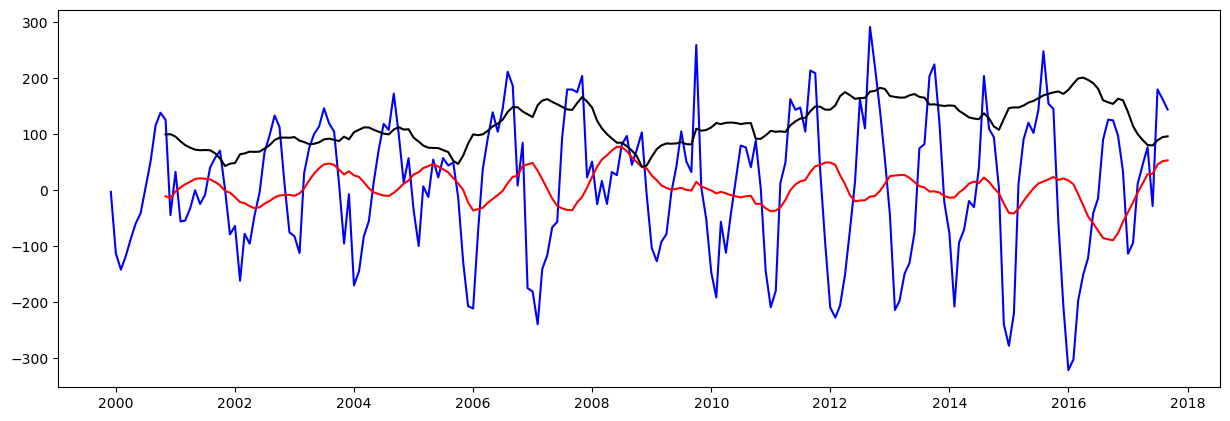

In [36]:
stationarity_test(DATASET[-1])

we have one more candidate to be our stationary series according to the test (but easy to see seasonality there..)

### Exponential Smoothing

In [37]:
expwighted_avg = DATA[1].ewm(span=12).mean()

Results of Dickey-Fuller Test:
(-1.5817770311092205, 0.49274071590206747, 14, 210, {'1%': -3.461878735881654, '5%': -2.875403665910809, '10%': -2.574159410430839}, 1570.3177706820798)
Test Statistic                  -1.581777
p-value                          0.492741
#Lags Used                      14.000000
Number of Observations Used    210.000000
Critical Value (1%)             -3.461879
Critical Value (5%)             -2.875404
Critical Value (10%)            -2.574159
dtype: float64


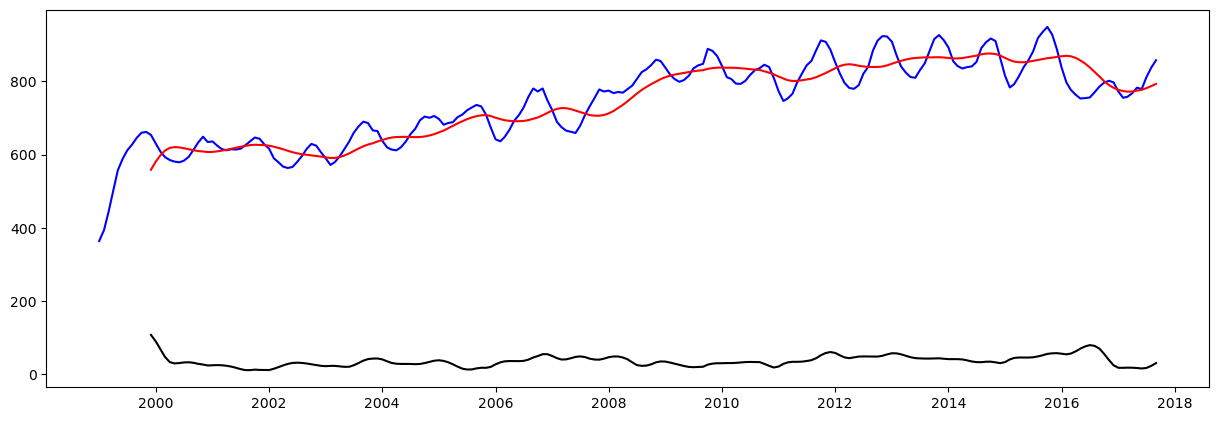

In [38]:
stationarity_test(expwighted_avg)

<AxesSubplot:>

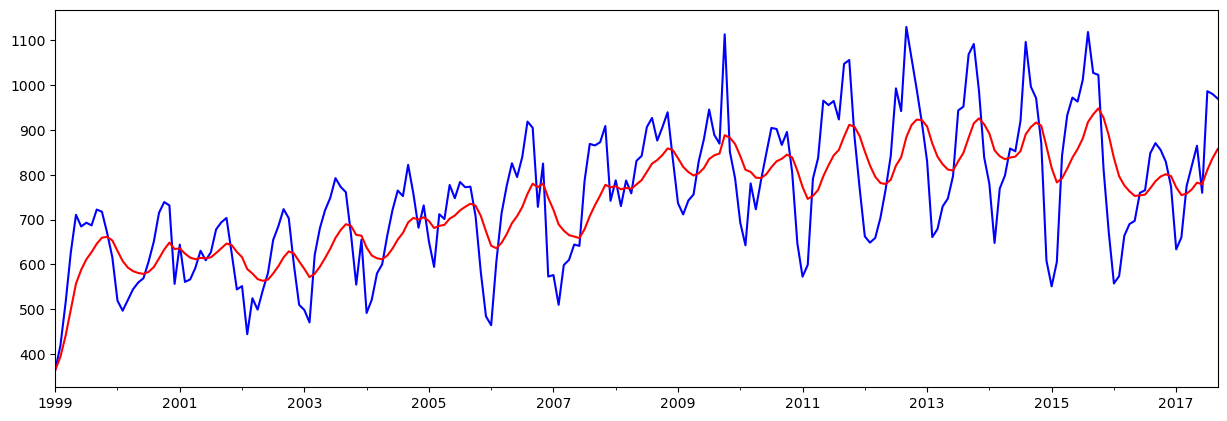

In [39]:
DATA[1].plot(color="blue", label="Original")
expwighted_avg.plot(color="red", label="EWMA")

<AxesSubplot:>

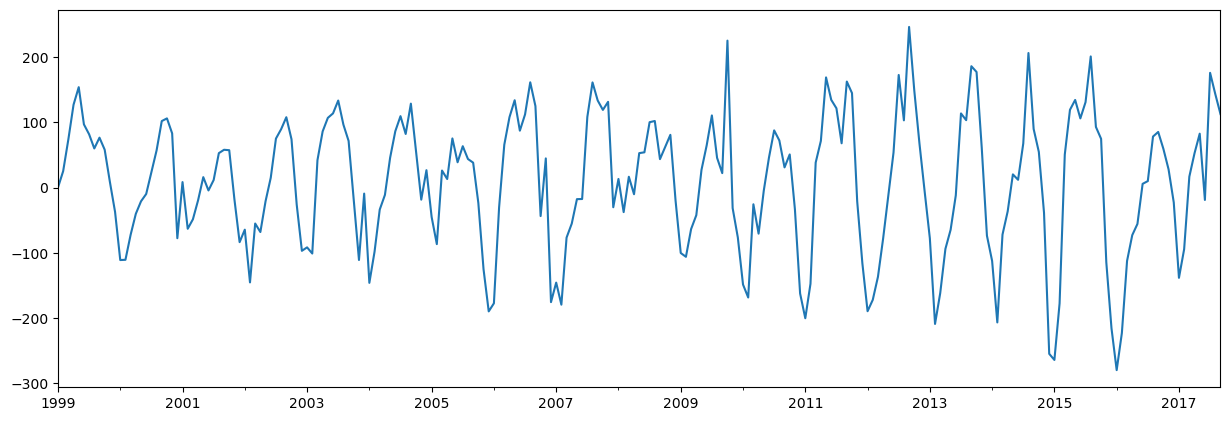

In [40]:
ts_exp_diff = DATA[1] - expwighted_avg
ts_exp_diff.plot()

Results of Dickey-Fuller Test:
(-5.64057835874004, 1.0387770456907763e-06, 13, 211, {'1%': -3.46172743446274, '5%': -2.8753374677799957, '10%': -2.574124089081557}, 2282.2270404068167)
Test Statistic                  -5.640578
p-value                          0.000001
#Lags Used                      13.000000
Number of Observations Used    211.000000
Critical Value (1%)             -3.461727
Critical Value (5%)             -2.875337
Critical Value (10%)            -2.574124
dtype: float64


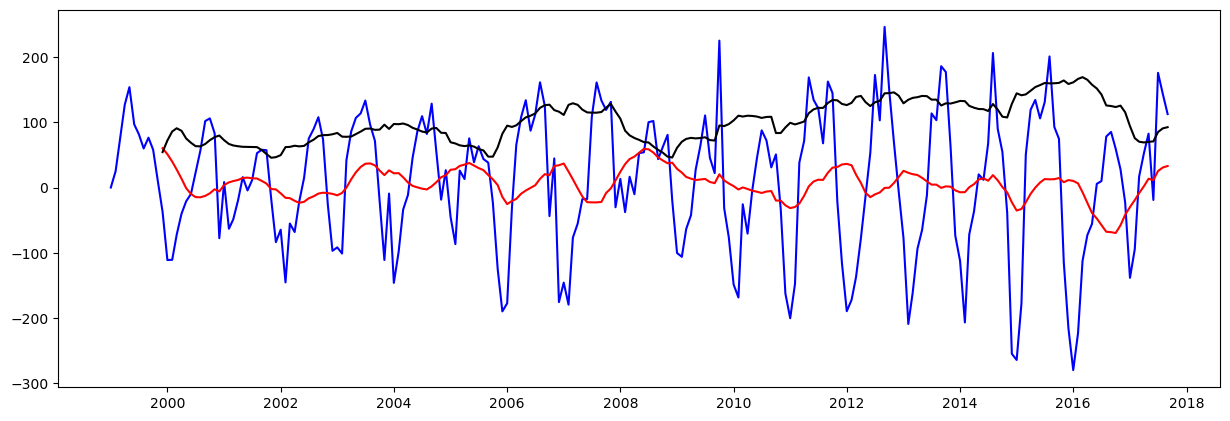

In [41]:
stationarity_test(ts_exp_diff)

and one more candidate for predictions

In [42]:
DATASET.append(ts_exp_diff)

In [43]:
len(DATASET)
DATASET = [each.dropna() for each in DATASET]

#### NOW WE HAVE FIVE STATIONARY  SERIES
all of them are in the DATASET array. 
- DATASET[0] - residuals got after splitting input data using decomposition and suppose that it is additive
- DATASET[1] - residuals got after splitting input data using decomposition and suppose that it is multiplictive
- DATASET[2] - series got using differencing
- DATASET[3] - series got after substracting all features that was found with MA
- DATASET[4] - series got after substracting all features that was found with EWMA
# **ALL next plots will be in this order **


## Simple Average (just for training)

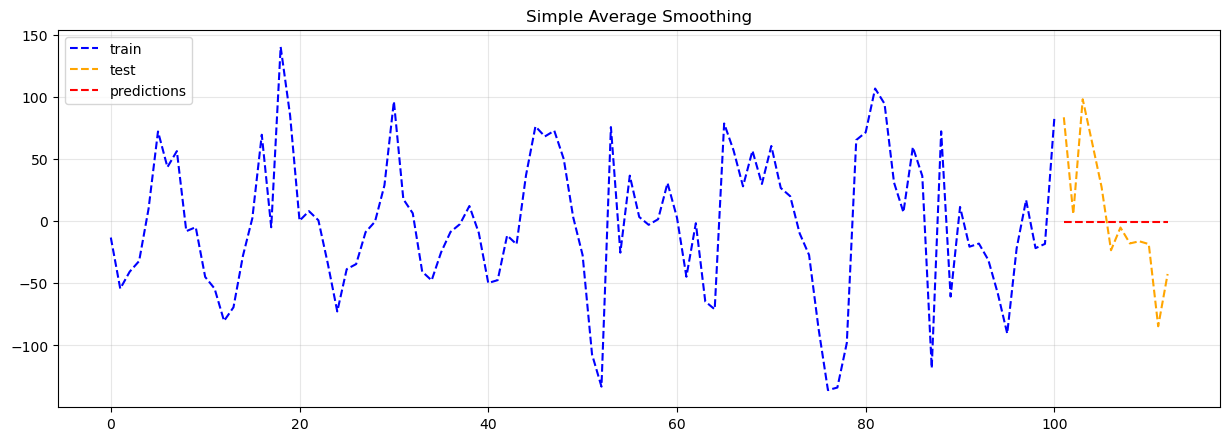

MSE = 2658.4447230111255


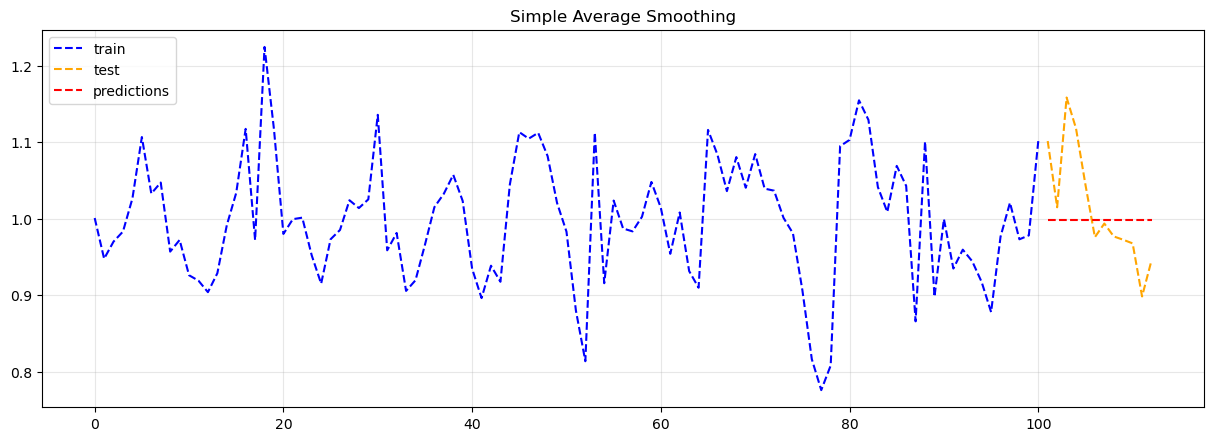

MSE = 0.005680950203126845


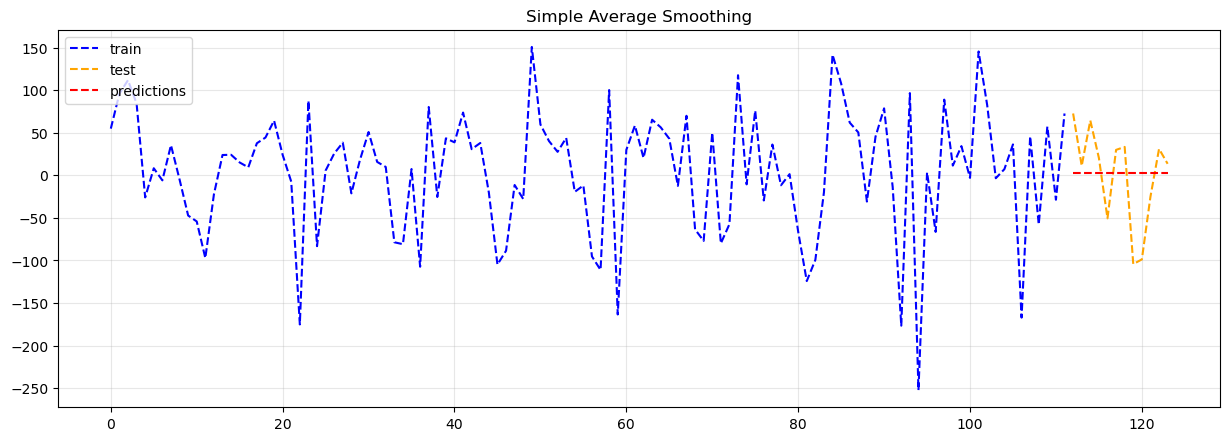

MSE = 3082.5112795256864


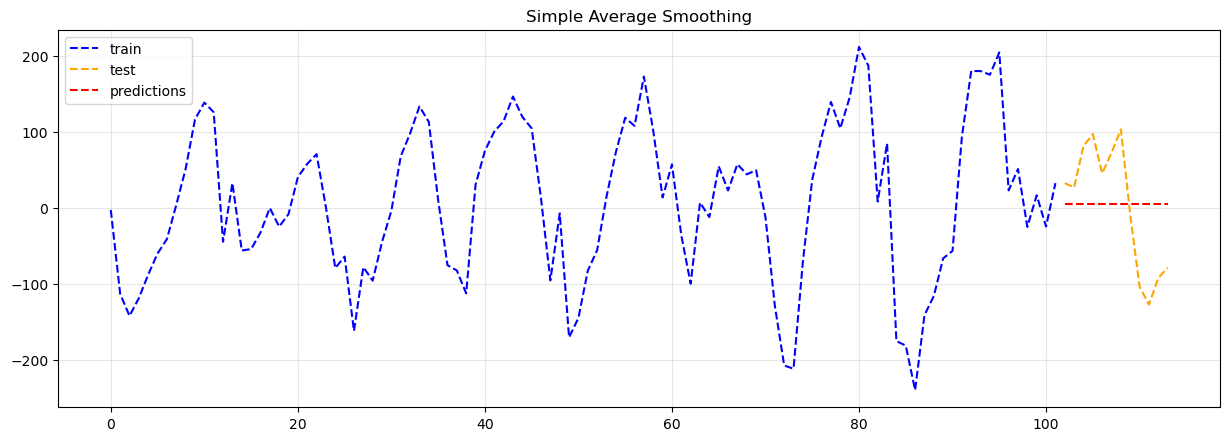

MSE = 6414.368955405913


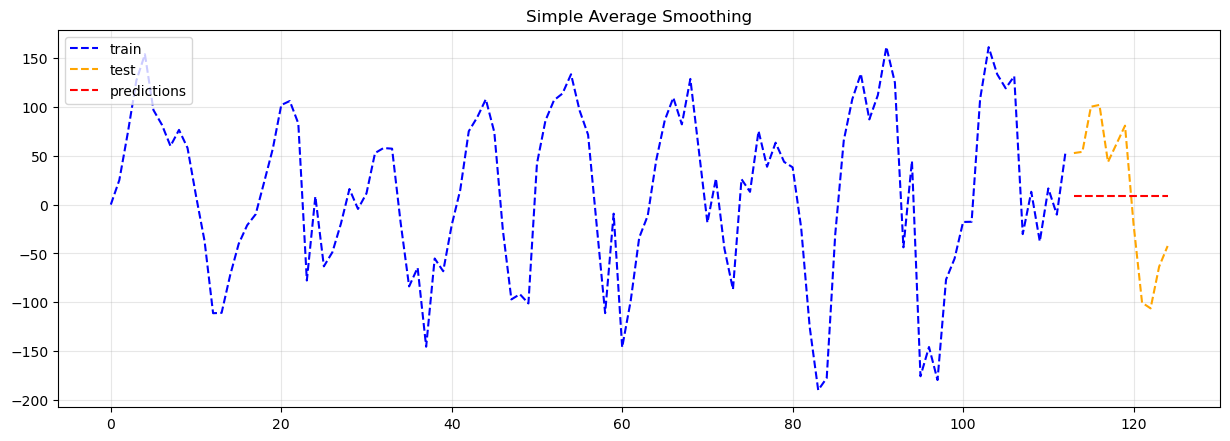

MSE = 5339.161134389237


In [44]:

for counter in range(len(DATASET)):
    train = DATASET[counter][:-112]
    test = DATASET[counter][-113:-101]
    trend_seasonal_avg = np.mean(DATASET[counter])
    time = np.arange(len(DATASET[counter]) - 100)
    simple_avg_preds = np.full(shape=12, fill_value=trend_seasonal_avg, dtype='float')
    plt.plot(time[:-12], train, 'b--', label="train")
    plt.plot(time[-12:], test, color='orange', linestyle="--", label="test")
    plt.plot(time[-12:], simple_avg_preds, 'r--', label="predictions")
    plt.legend(loc='upper left')
    plt.title("Simple Average Smoothing")
    plt.grid(alpha=0.3)
    plt.show();
    
    print("MSE = {}".format(mse(test, simple_avg_preds)))

useless (especcialy in this case)

### Triple Exponential

/usr/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



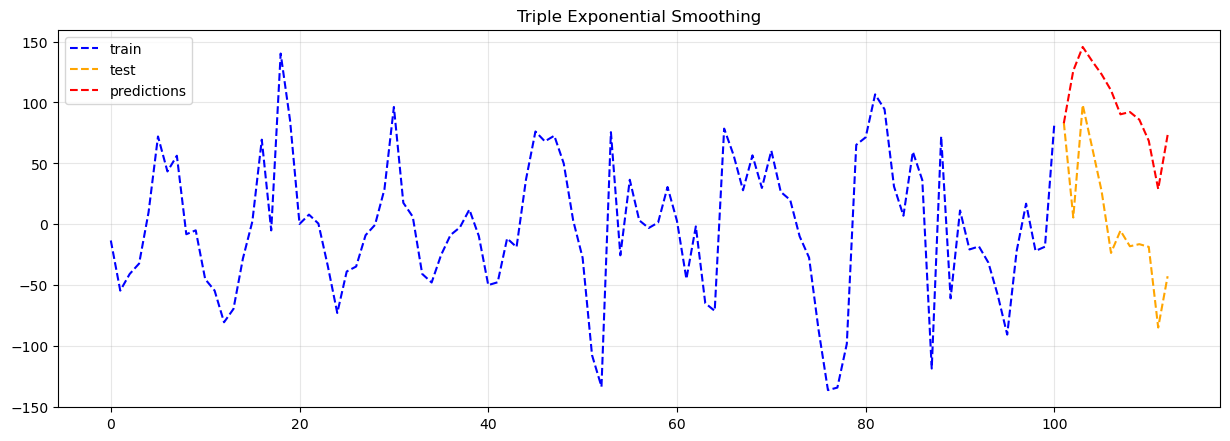

MSE = 9528.189822349565


/usr/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



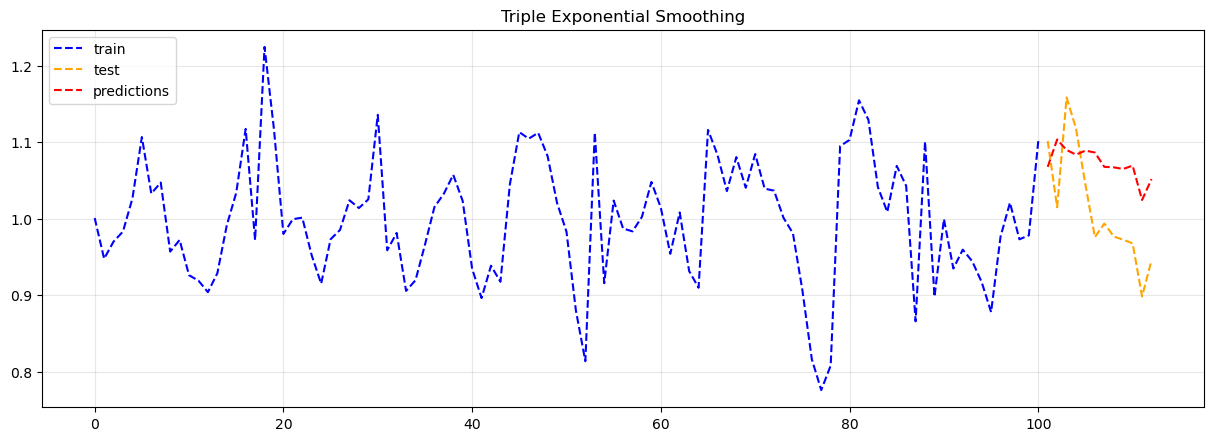

MSE = 0.007391512628542099


/usr/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



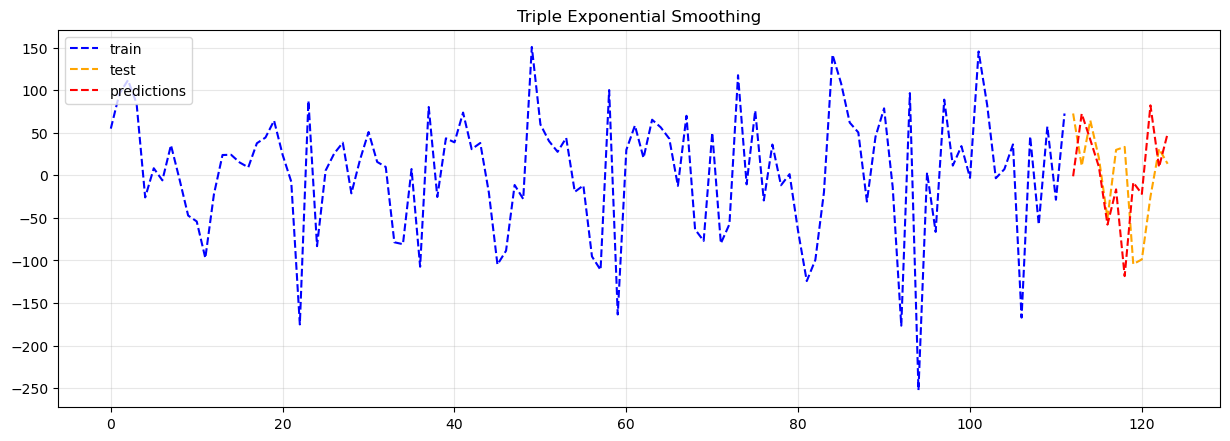

MSE = 5279.81654480602


/usr/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



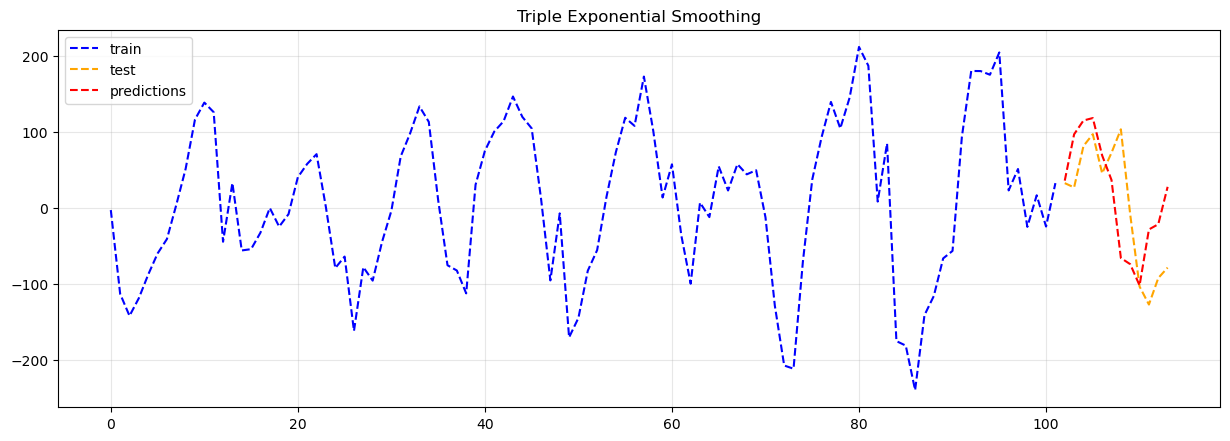

MSE = 5587.478328020381


/usr/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



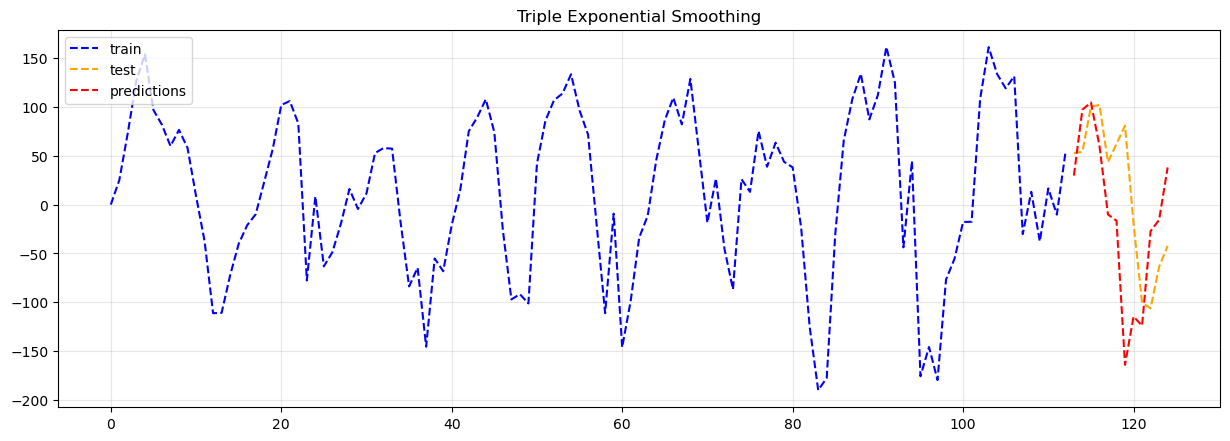

MSE = 8132.906398479302


In [45]:
i = 0
for counter in range(len(DATASET)):
    i += 1
    train = DATASET[counter][:-112]
    test = DATASET[counter][-113:-101]
    time = np.arange(len(DATASET[counter]) -100)
    if (i == 2):
        triple = ExponentialSmoothing(train,
                              trend="multiplicative",
                              seasonal="multiplicative",
                              seasonal_periods=12).fit(optimized=True)
    else:
        triple = ExponentialSmoothing(train,
                              trend="additive",
                              seasonal="additive",
                              seasonal_periods=12).fit(optimized=True)
    triple_preds = triple.forecast(len(test))
    
    plt.plot(time[:-12], train, 'b--', label="train")
    plt.plot(time[-12:], test, color='orange', linestyle="--", label="test")
    plt.plot(time[-12:], triple_preds, 'r--', label="predictions")
    plt.legend(loc='upper left')
    plt.title("Triple Exponential Smoothing")
    plt.grid(alpha=0.3);
    plt.show()
    
    print("MSE = {}".format(mse(test, triple_preds)))

we can see that this approach gives us not bad predictions

# AR, MA, ARMA, ARIMA, (SARIMAX MODULE)

In [46]:
def MAPE(data, fit):
    return 100*(np.average(abs((fit-data)/data)))

In [47]:
# define helper plot function for visualization

def plots(data, lags=None):
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    data.plot(ax=raw)
    smt.graphics.plot_acf(data, lags=lags, ax=acf)
    smt.graphics.plot_pacf(data, lags=lags, ax=pacf)
    sns.despine()
    plt.tight_layout()
    plt.show()
    
    

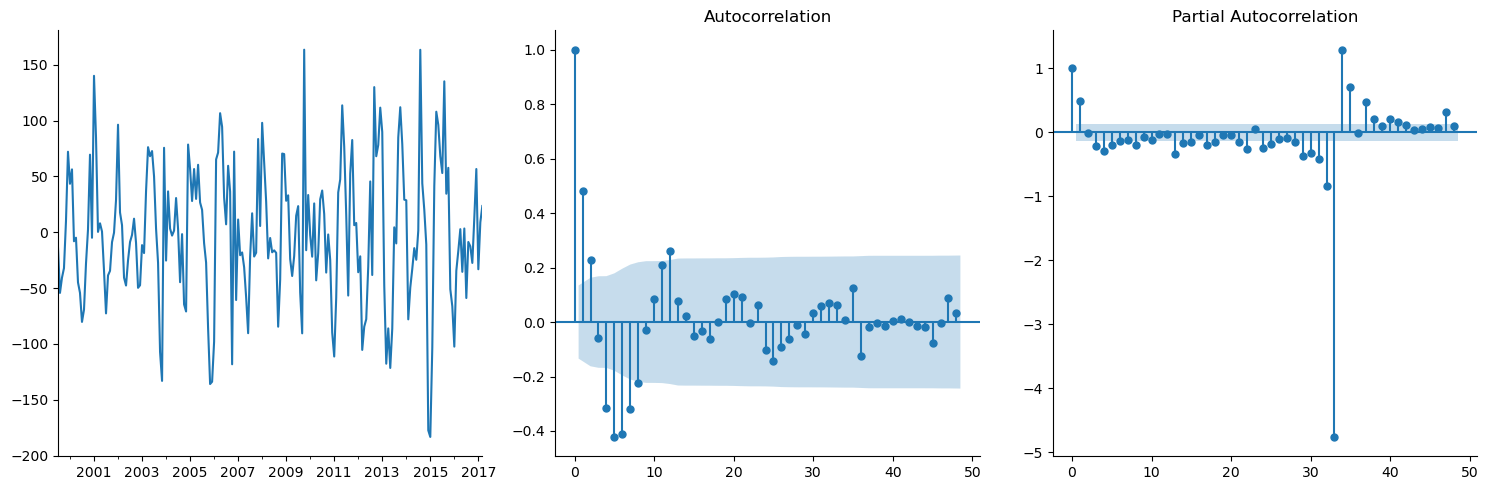

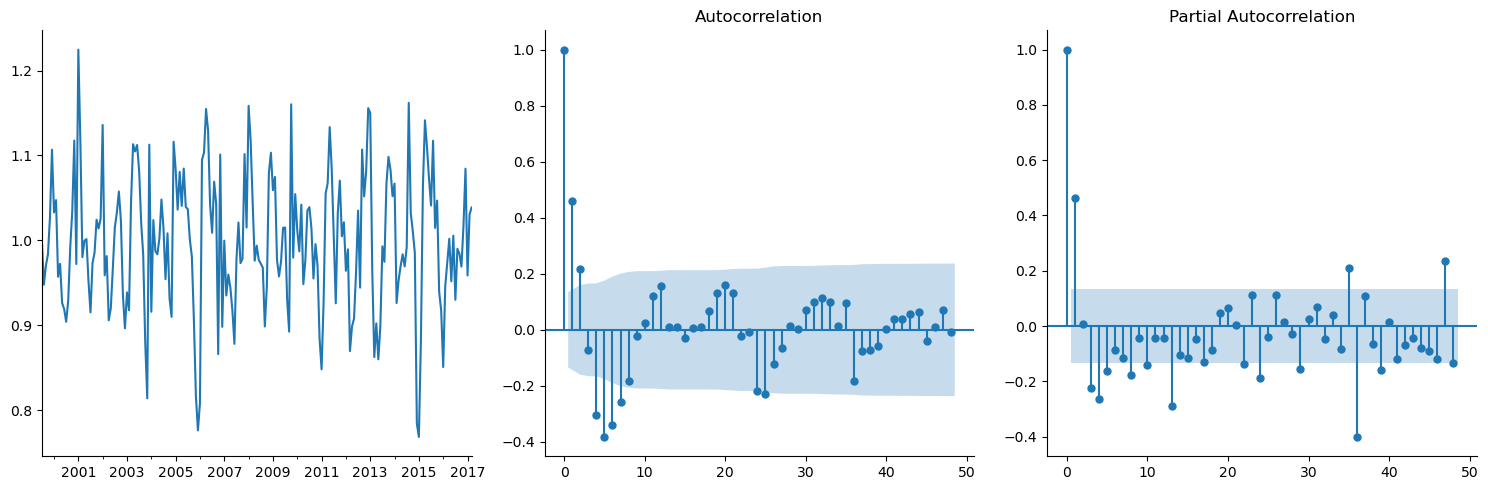

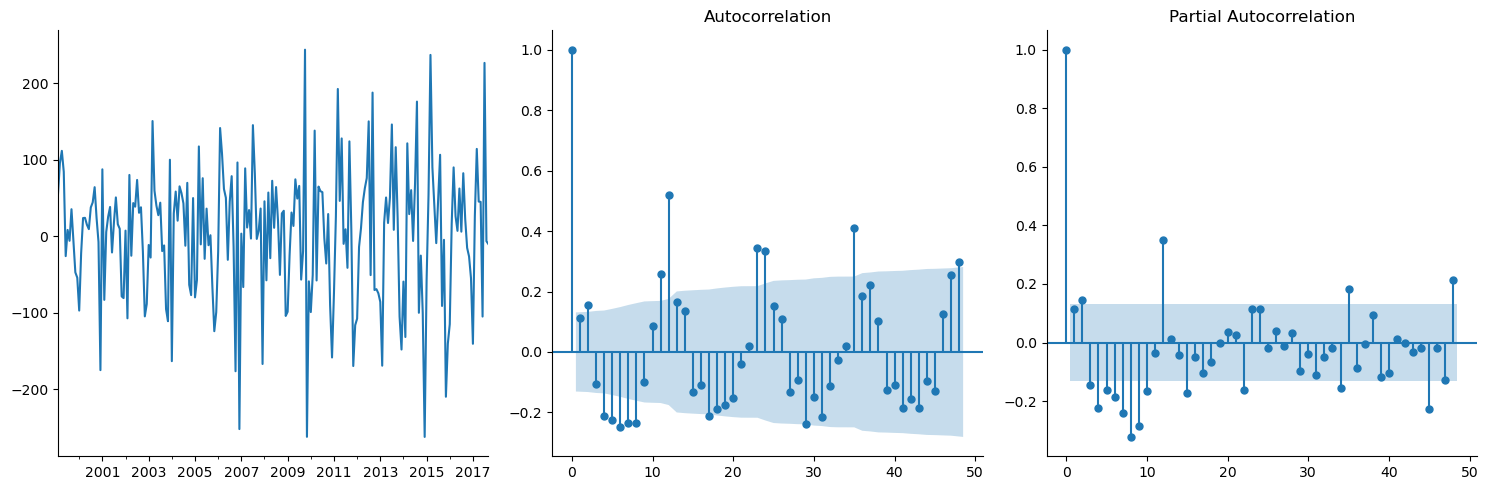

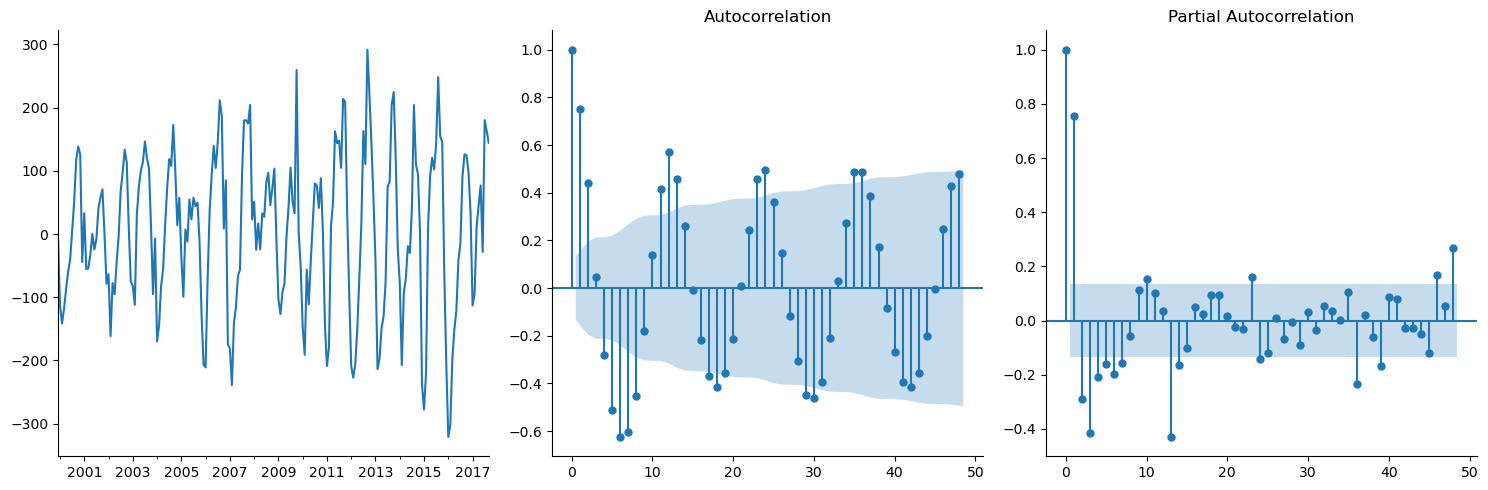

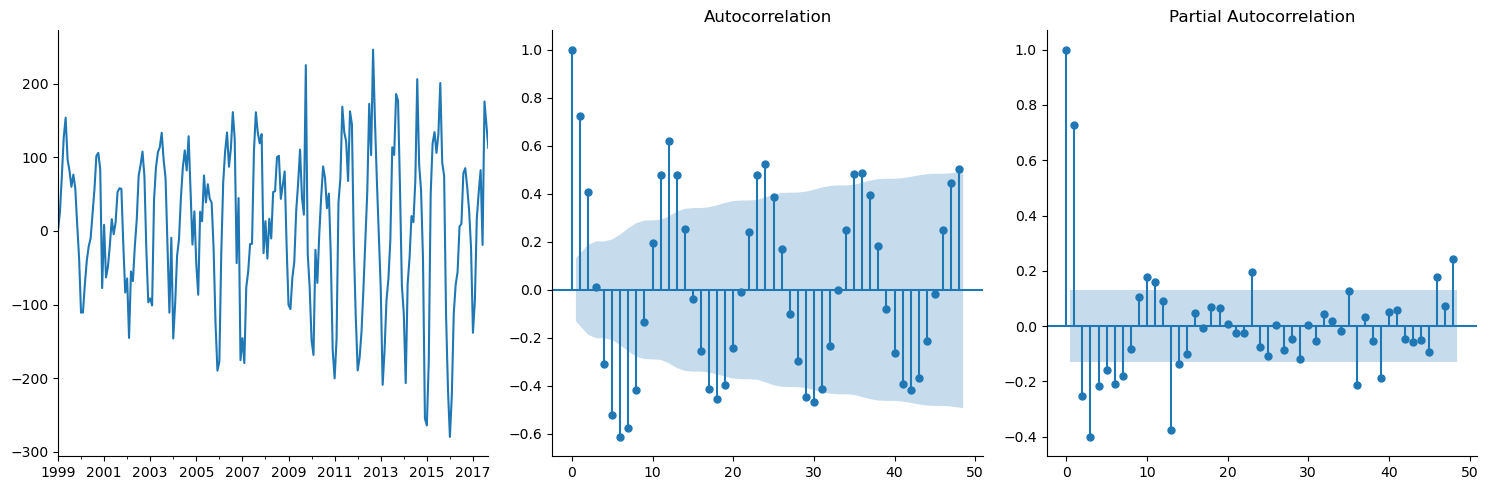

In [48]:
for each in DATASET:
    plots(each, lags=48);

according to autocorelation function results, p=3 (4th zeo) <br>
according to partial autocorelation function results, q=2 (3d zero)

# AR


/usr/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



Figure(1500x500)


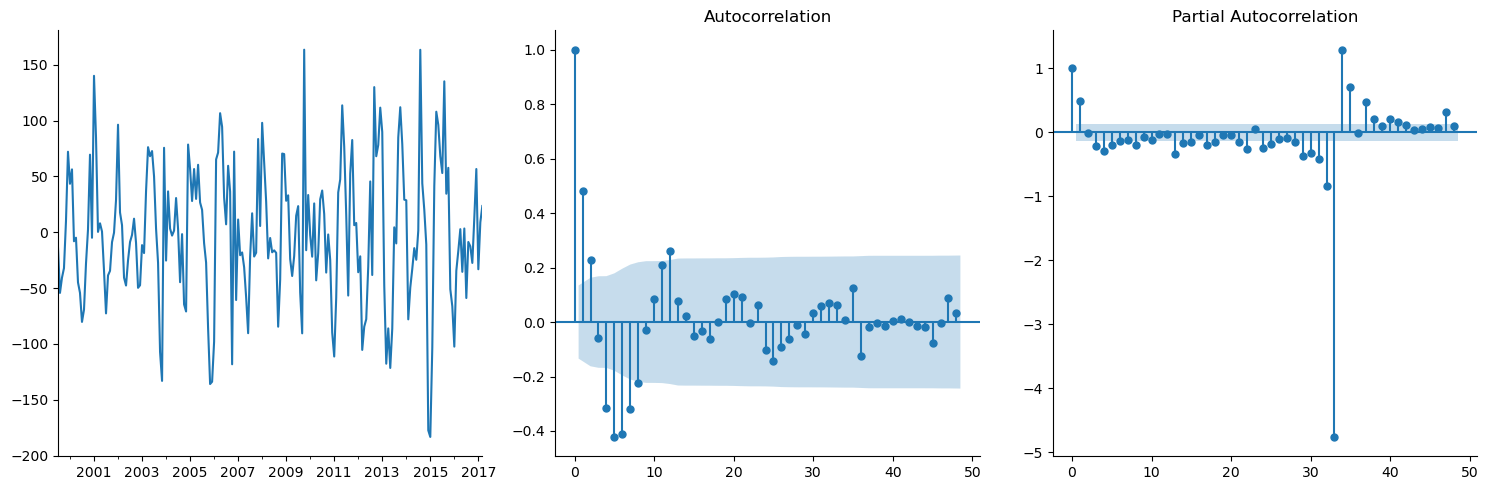

                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                  213
Model:               SARIMAX(3, 0, 0)   Log Likelihood               -1147.787
Date:                Sat, 10 Oct 2020   AIC                           2305.574
Time:                        00:38:01   BIC                           2322.381
Sample:                    07-01-1999   HQIC                          2312.366
                         - 03-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.2537      3.893     -0.065      0.948      -7.883       7.376
ar.L1          0.4815      0.061      7.919      0.000       0.362       0.601
ar.L2          0.0973      0.079      1.235      0.2

/usr/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



Figure(1500x500)


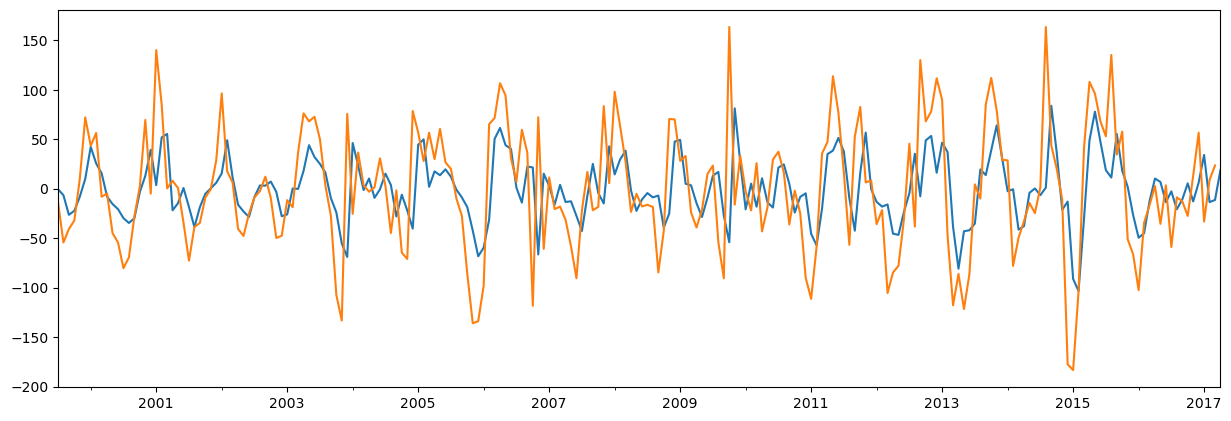

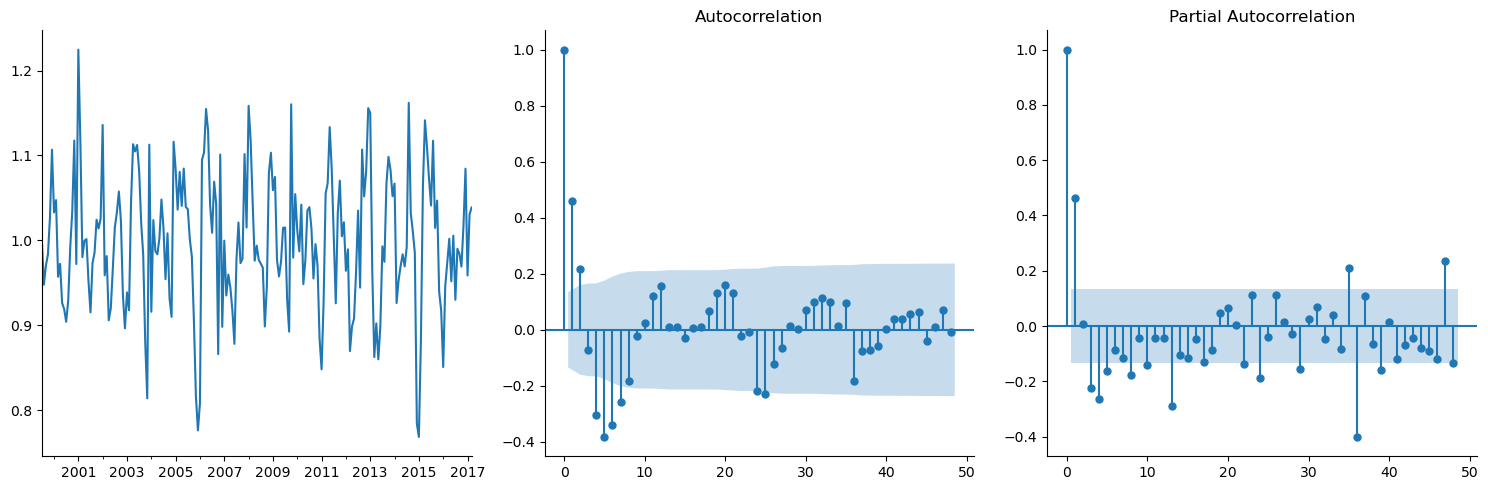

                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                  213
Model:               SARIMAX(3, 0, 0)   Log Likelihood                 266.850
Date:                Sat, 10 Oct 2020   AIC                           -523.701
Time:                        00:38:01   BIC                           -506.894
Sample:                    07-01-1999   HQIC                          -516.909
                         - 03-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.6527      0.076      8.544      0.000       0.503       0.802
ar.L1          0.4584      0.060      7.699      0.000       0.342       0.575
ar.L2          0.1060      0.074      1.437      0.1

/usr/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



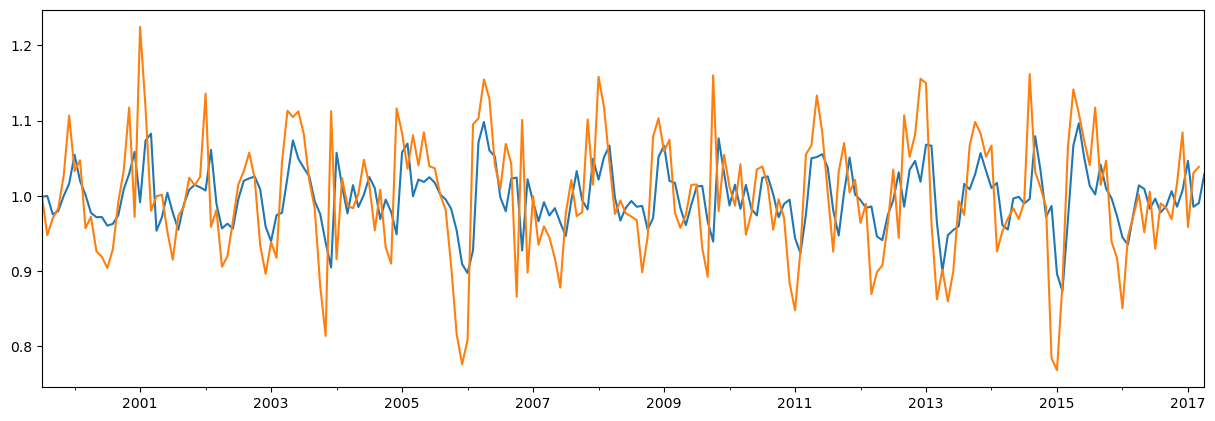

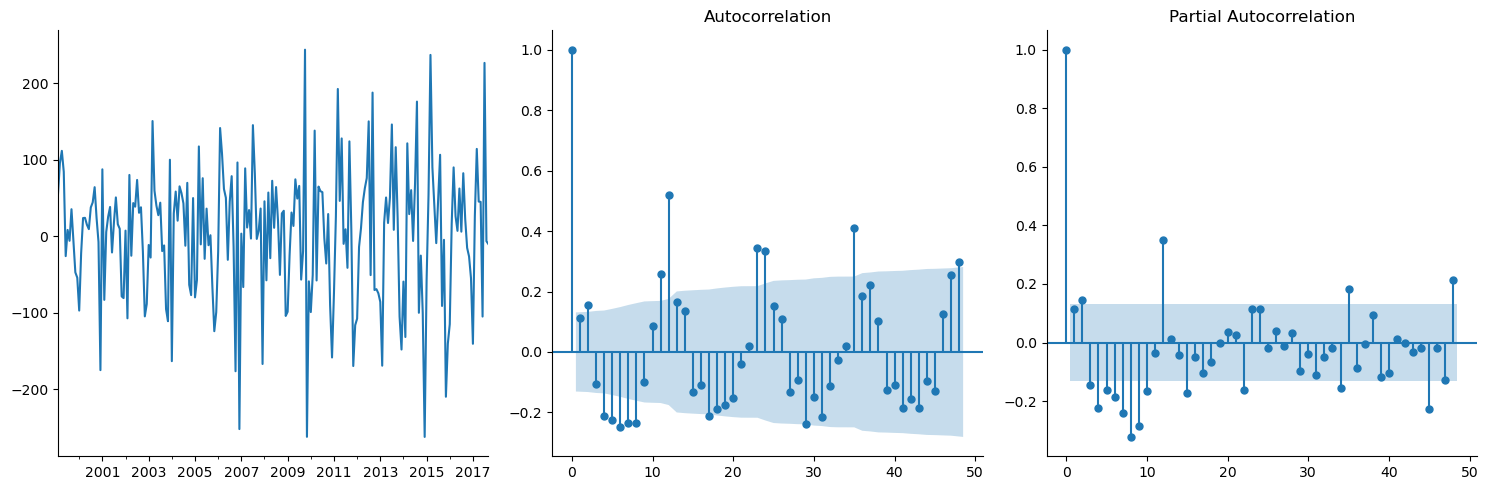

                               SARIMAX Results                                
Dep. Variable:             Production   No. Observations:                  224
Model:               SARIMAX(3, 0, 0)   Log Likelihood               -1308.585
Date:                Sat, 10 Oct 2020   AIC                           2627.169
Time:                        00:38:02   BIC                           2644.227
Sample:                    02-01-1999   HQIC                          2634.055
                         - 09-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.1518      5.733      0.375      0.707      -9.085      13.389
ar.L1          0.1185      0.060      1.974      0.048       0.001       0.236
ar.L2          0.1568      0.070      2.229      0.0

/usr/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



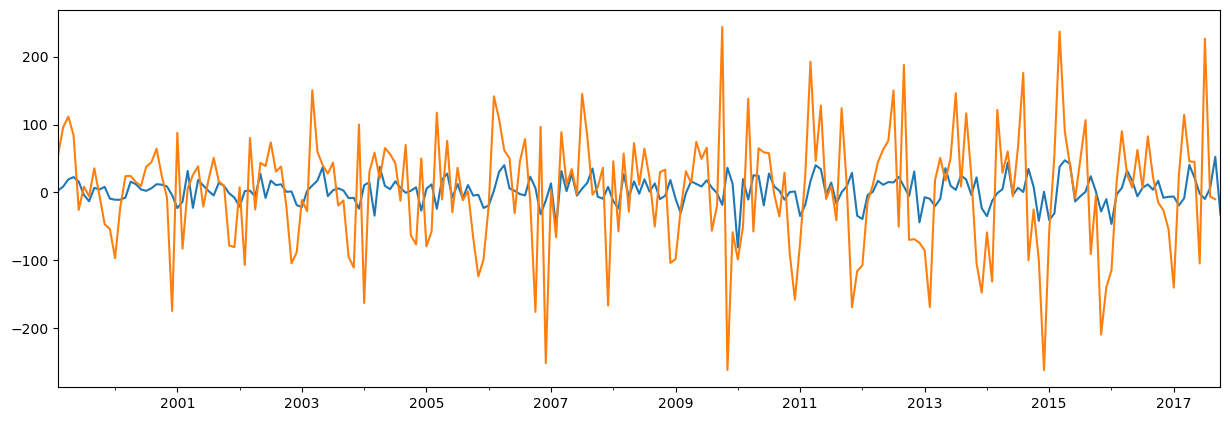

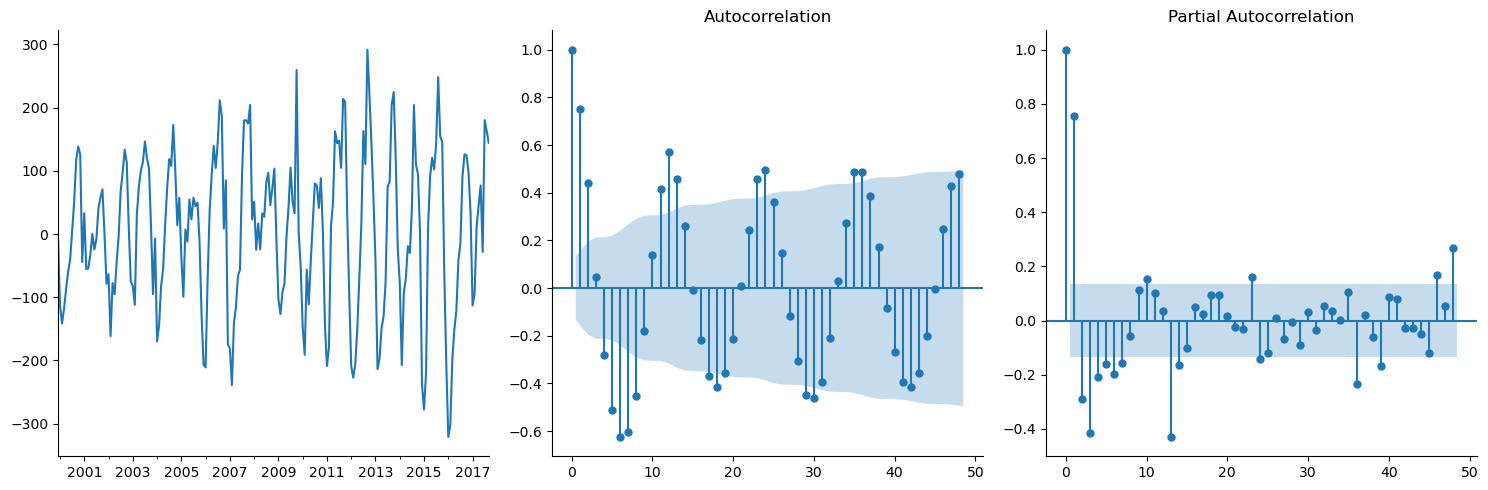

                               SARIMAX Results                                
Dep. Variable:             Production   No. Observations:                  214
Model:               SARIMAX(3, 0, 0)   Log Likelihood               -1213.881
Date:                Sat, 10 Oct 2020   AIC                           2437.762
Time:                        00:38:03   BIC                           2454.592
Sample:                    12-01-1999   HQIC                          2444.563
                         - 09-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.5824      5.300      0.487      0.626      -7.804      12.969
ar.L1          0.8489      0.058     14.606      0.000       0.735       0.963
ar.L2          0.1073      0.080      1.337      0.1

/usr/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



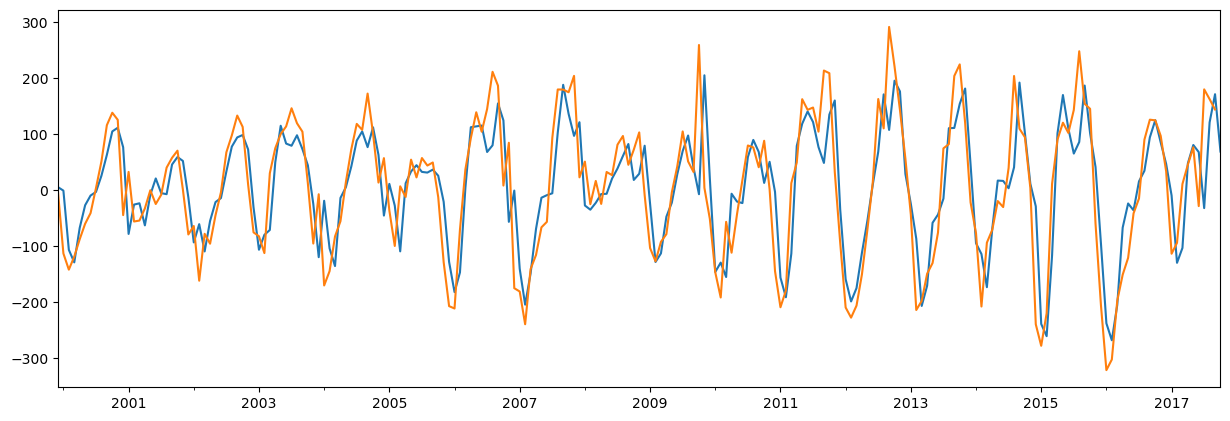

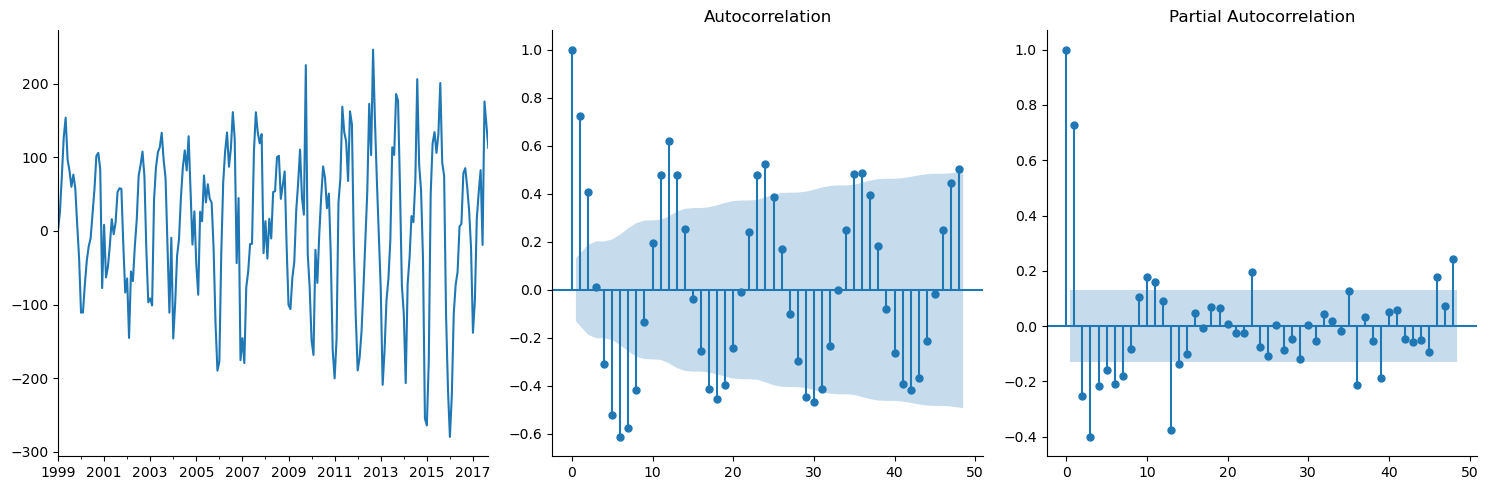

                               SARIMAX Results                                
Dep. Variable:             Production   No. Observations:                  225
Model:               SARIMAX(3, 0, 0)   Log Likelihood               -1252.739
Date:                Sat, 10 Oct 2020   AIC                           2515.478
Time:                        00:38:03   BIC                           2532.559
Sample:                    01-01-1999   HQIC                          2522.372
                         - 09-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.5583      4.655      0.764      0.445      -5.565      12.682
ar.L1          0.8046      0.055     14.519      0.000       0.696       0.913
ar.L2          0.1069      0.076      1.404      0.1

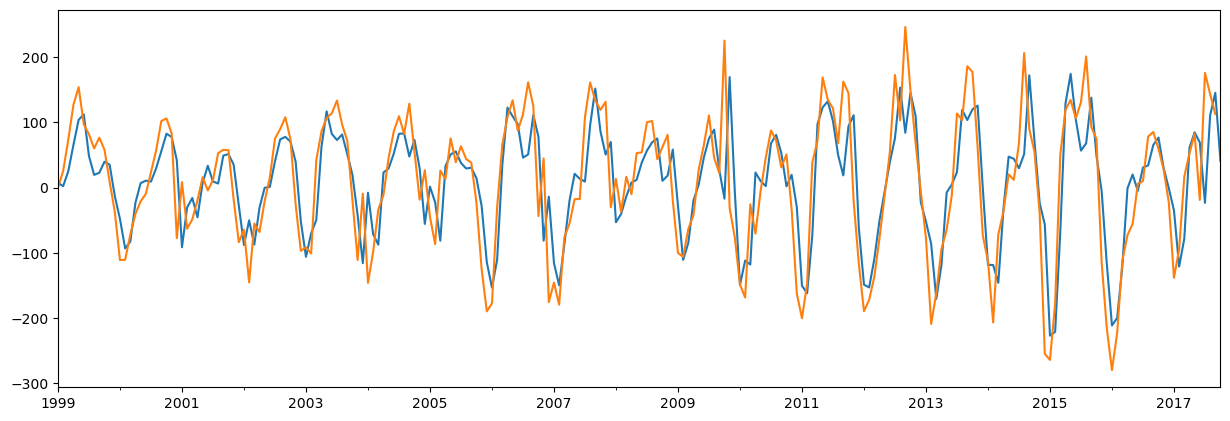

In [49]:

for dt in DATASET:

    # fit SARIMA monthly based on helper plots
    sar = sm.tsa.statespace.SARIMAX(dt, 
                                    order=(3,0,0),  
                                    trend='c').fit()

    print(sar.plot_diagnostics())
    plots(dt, lags=48)
    print(sar.summary())
    res = sar.predict(start = 0, end= len(dt), dynamic=False)
    res.plot()
    dt.plot()
    
    print("MSE = {}".format(mse(dt, res[:-1])))
    print("MAPE = {}".format(MAPE(dt, res[:-1])))

# MA

/usr/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



Figure(1500x500)


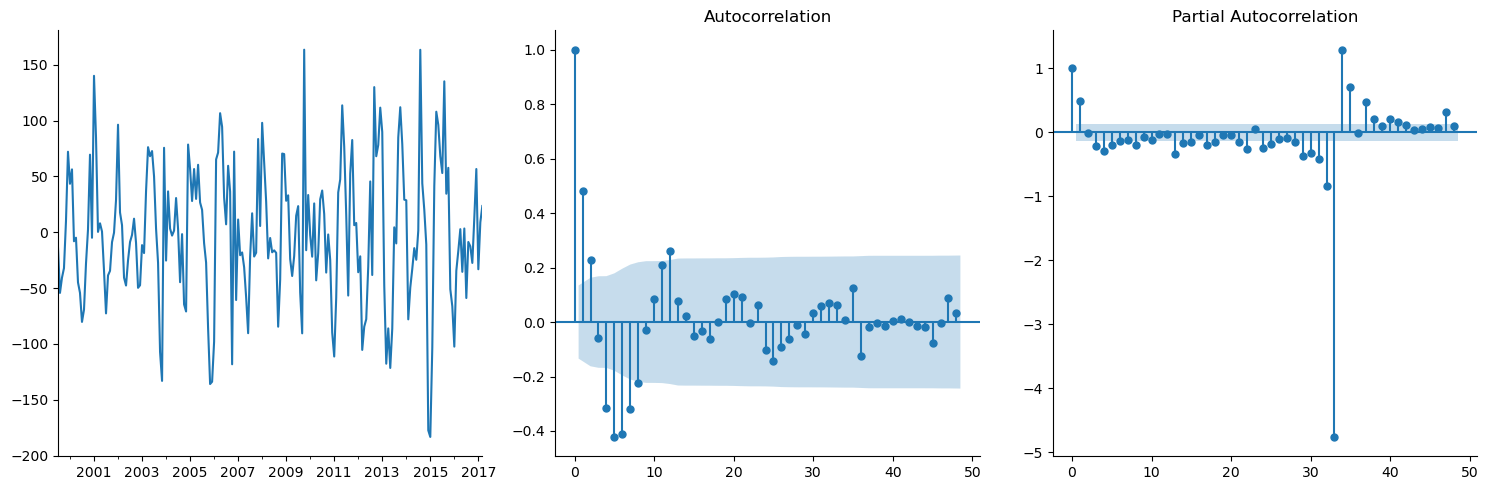

                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                  213
Model:               SARIMAX(0, 0, 2)   Log Likelihood               -1152.305
Date:                Sat, 10 Oct 2020   AIC                           2312.609
Time:                        00:38:04   BIC                           2326.054
Sample:                    07-01-1999   HQIC                          2318.043
                         - 03-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.1964      6.513     -0.030      0.976     -12.961      12.568
ma.L1          0.4275      0.059      7.305      0.000       0.313       0.542
ma.L2          0.2525      0.076      3.332      0.0

/usr/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



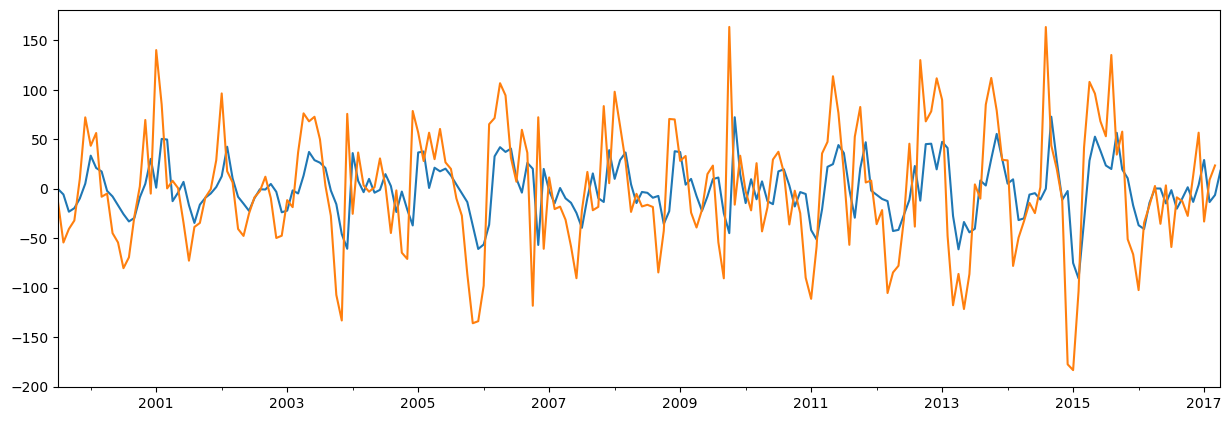

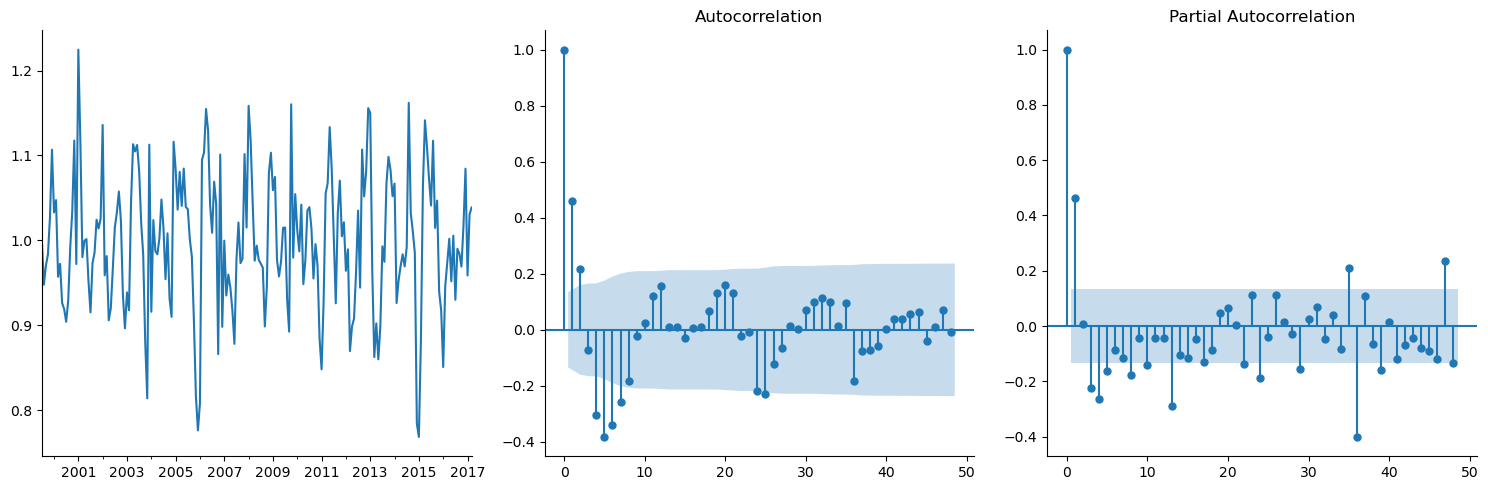

                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                  213
Model:               SARIMAX(0, 0, 2)   Log Likelihood                 262.759
Date:                Sat, 10 Oct 2020   AIC                           -517.519
Time:                        00:38:05   BIC                           -504.073
Sample:                    07-01-1999   HQIC                          -512.085
                         - 03-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.9989      0.008    120.000      0.000       0.983       1.015
ma.L1          0.4052      0.057      7.094      0.000       0.293       0.517
ma.L2          0.2574      0.070      3.683      0.0

/usr/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



Figure(1500x500)


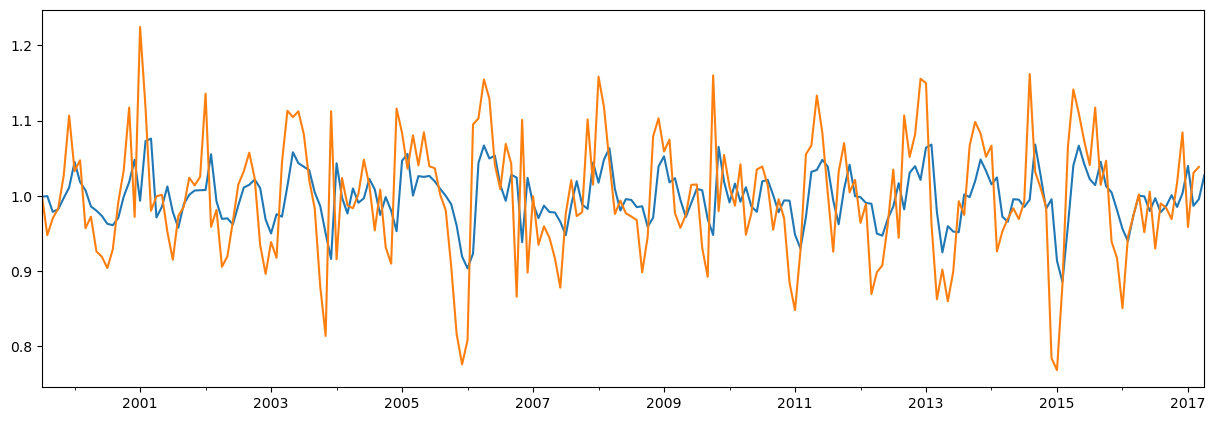

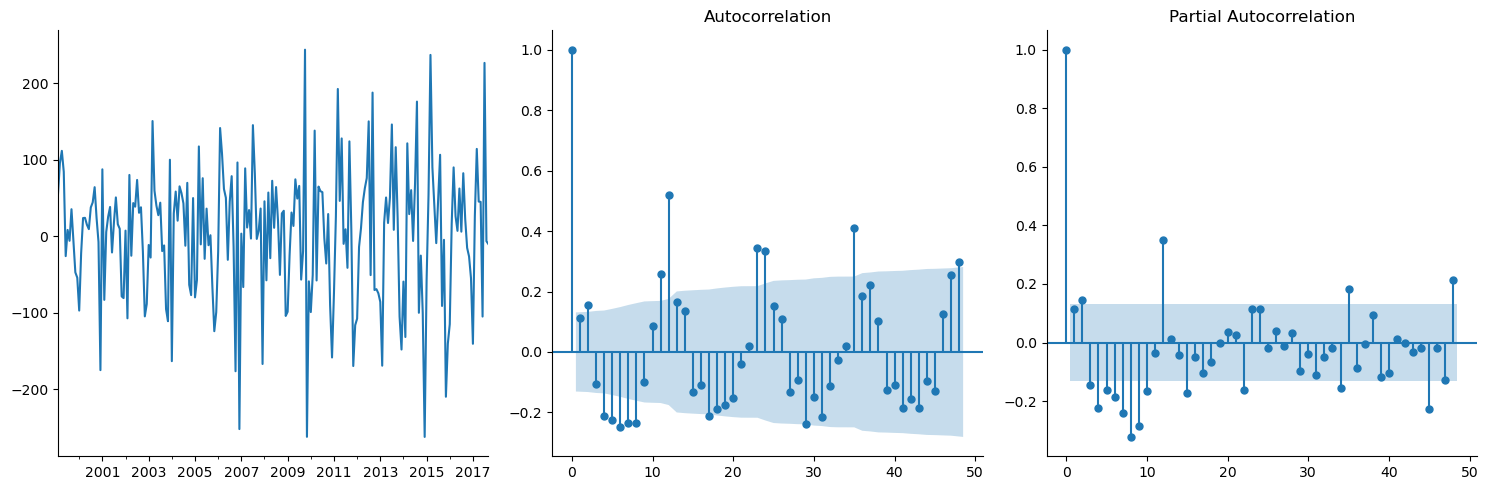

                               SARIMAX Results                                
Dep. Variable:             Production   No. Observations:                  224
Model:               SARIMAX(0, 0, 2)   Log Likelihood               -1308.844
Date:                Sat, 10 Oct 2020   AIC                           2625.688
Time:                        00:38:06   BIC                           2639.335
Sample:                    02-01-1999   HQIC                          2631.197
                         - 09-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.6936      7.673      0.351      0.726     -12.345      17.733
ma.L1          0.1129      0.055      2.067      0.039       0.006       0.220
ma.L2          0.2338      0.069      3.377      0.0

/usr/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



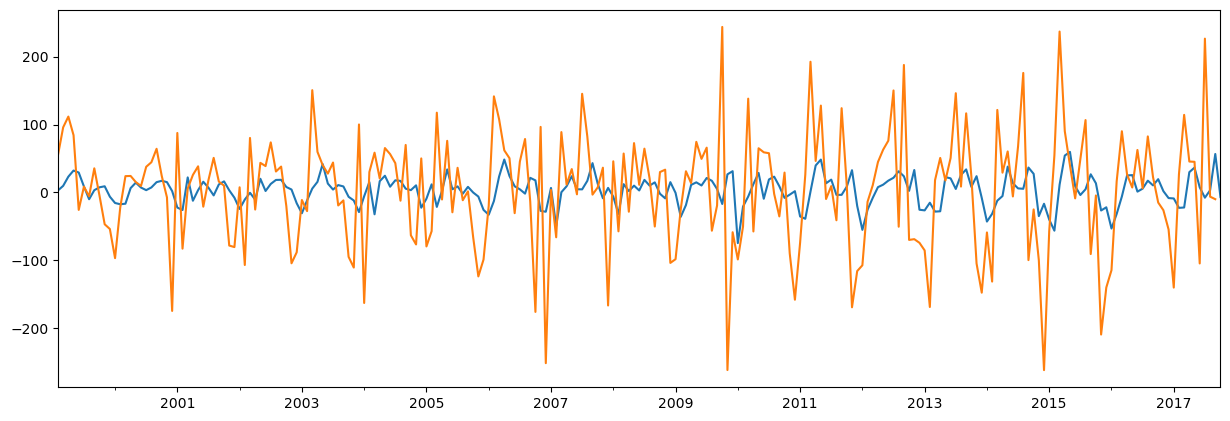

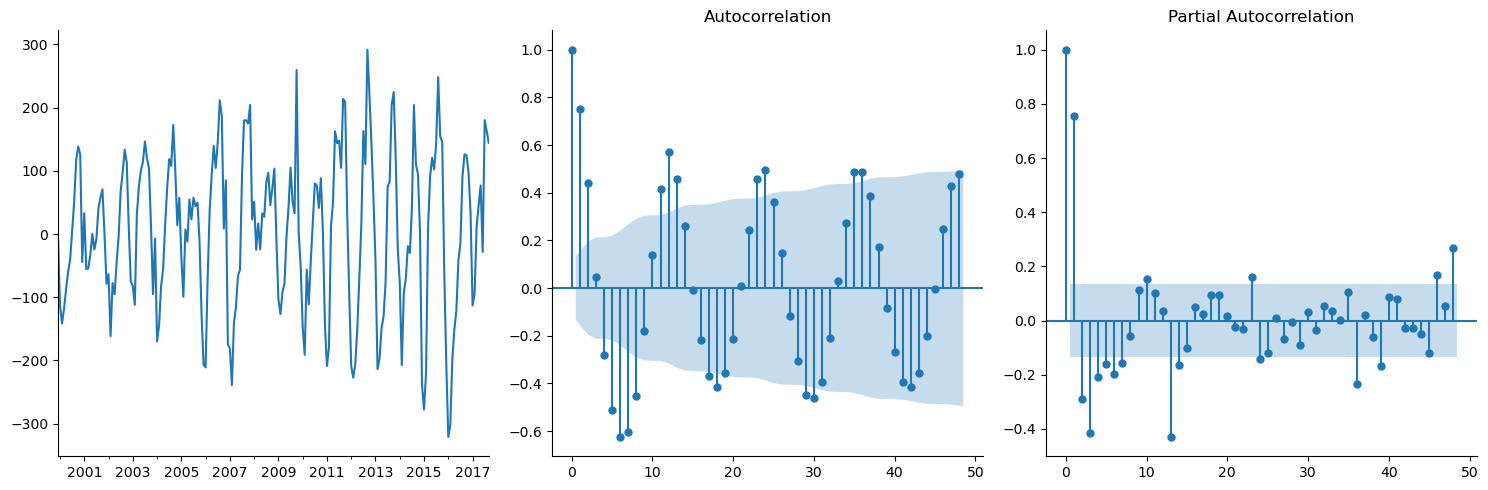

                               SARIMAX Results                                
Dep. Variable:             Production   No. Observations:                  214
Model:               SARIMAX(0, 0, 2)   Log Likelihood               -1240.944
Date:                Sat, 10 Oct 2020   AIC                           2489.887
Time:                        00:38:07   BIC                           2503.351
Sample:                    12-01-1999   HQIC                          2495.328
                         - 09-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.5810     12.307      0.291      0.771     -20.540      27.702
ma.L1          0.7531      0.058     13.076      0.000       0.640       0.866
ma.L2          0.4801      0.070      6.860      0.0

/usr/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



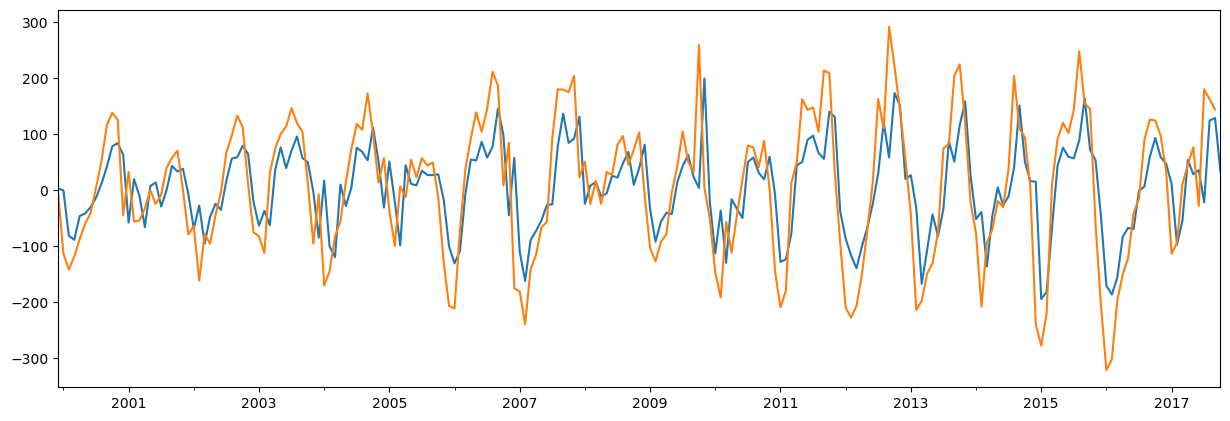

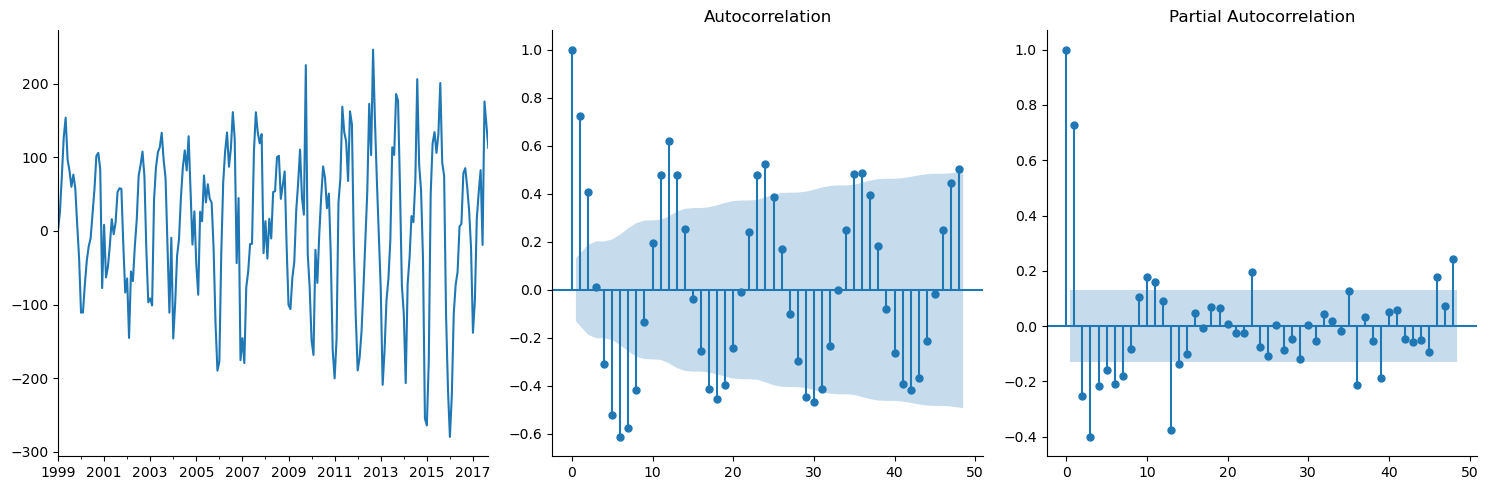

                               SARIMAX Results                                
Dep. Variable:             Production   No. Observations:                  225
Model:               SARIMAX(0, 0, 2)   Log Likelihood               -1276.378
Date:                Sat, 10 Oct 2020   AIC                           2560.757
Time:                        00:38:07   BIC                           2574.421
Sample:                    01-01-1999   HQIC                          2566.272
                         - 09-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      8.3563     10.356      0.807      0.420     -11.941      28.654
ma.L1          0.7079      0.055     12.955      0.000       0.601       0.815
ma.L2          0.4620      0.069      6.743      0.0

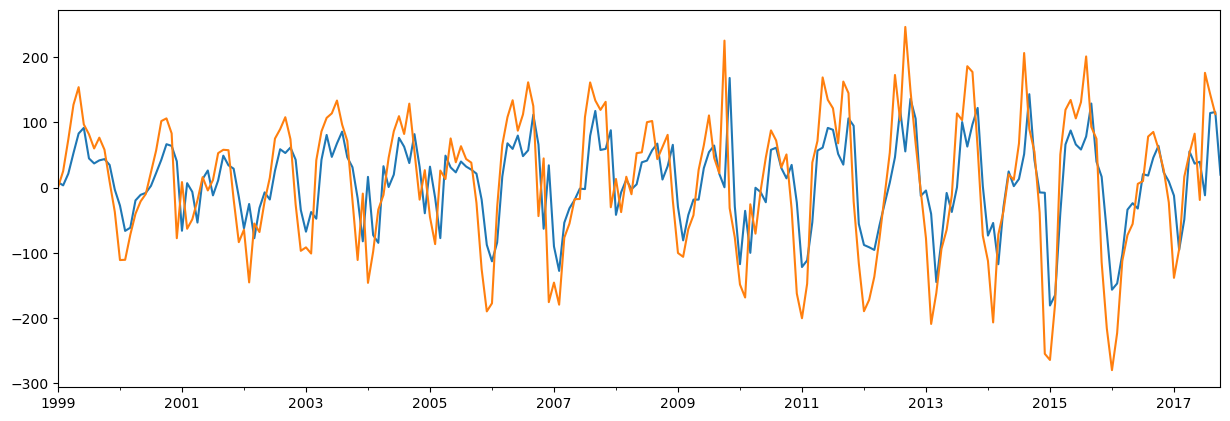

In [50]:

for dt in DATASET:

    # fit SARIMA monthly based on helper plots
    sar = sm.tsa.statespace.SARIMAX(dt, 
                                    order=(0,0,2),  
                                    trend='c').fit()

    print(sar.plot_diagnostics())
    plots(dt, lags=48)
    print(sar.summary())
    res = sar.predict(start = 0, end= len(dt), dynamic=False)
    res.plot()
    dt.plot()
    
    print("MSE = {}".format(mse(dt, res[:-1])))
    print("MAPE = {}".format(MAPE(dt, res[:-1])))

# ARMA

/usr/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



Figure(1500x500)


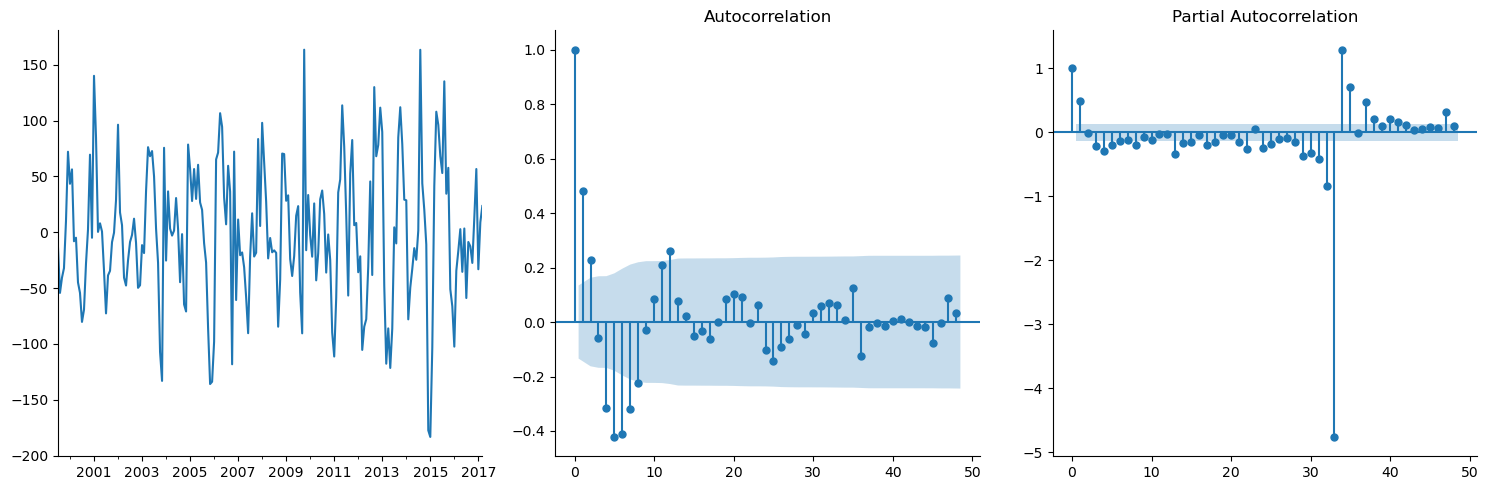

                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                  213
Model:               SARIMAX(3, 0, 2)   Log Likelihood               -1114.721
Date:                Sat, 10 Oct 2020   AIC                           2243.441
Time:                        00:58:32   BIC                           2266.970
Sample:                    07-01-1999   HQIC                          2252.950
                         - 03-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0073      0.014      0.528      0.597      -0.020       0.034
ar.L1          1.9413      0.121     16.019      0.000       1.704       2.179
ar.L2         -1.2807      0.190     -6.736      0.0

/usr/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Figure(1500x500)


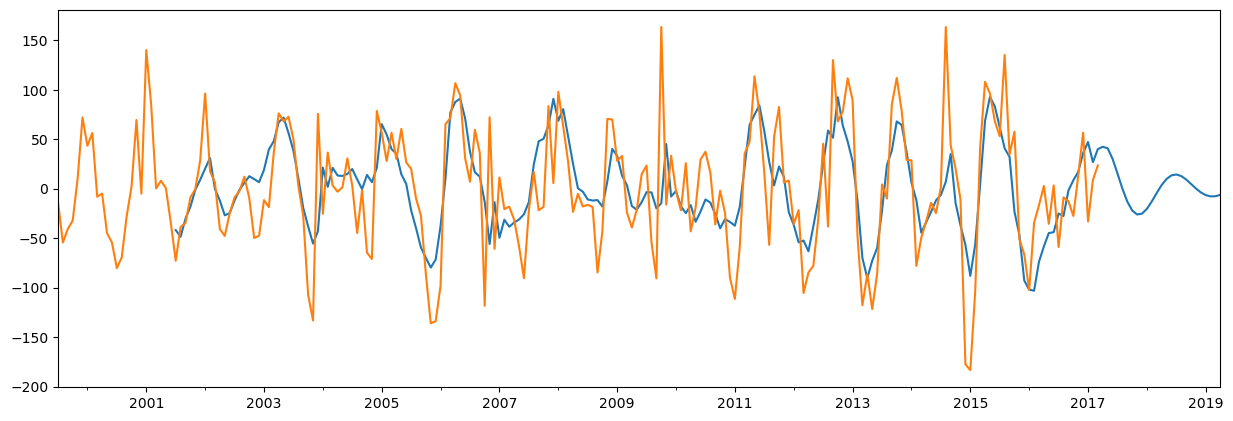

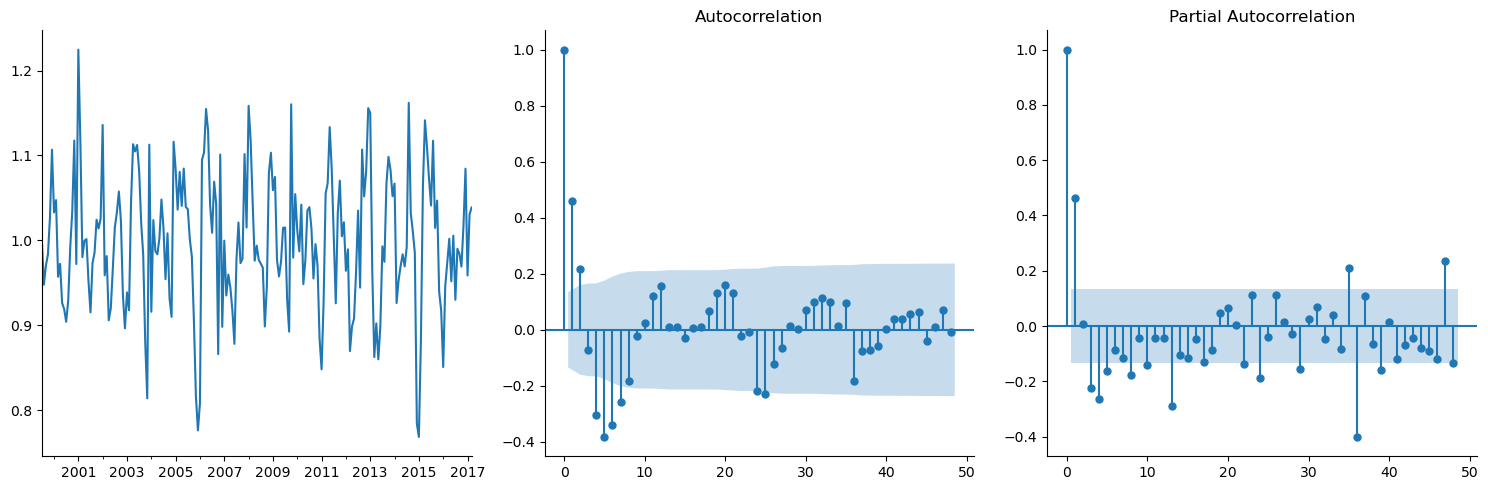

                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                  213
Model:               SARIMAX(3, 0, 2)   Log Likelihood                 283.259
Date:                Sat, 10 Oct 2020   AIC                           -552.517
Time:                        00:58:33   BIC                           -528.988
Sample:                    07-01-1999   HQIC                          -543.008
                         - 03-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3517      0.078      4.498      0.000       0.198       0.505
ar.L1          0.8244      0.280      2.944      0.003       0.276       1.373
ar.L2          0.2946      0.386      0.763      0.4

/usr/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



Figure(1500x500)


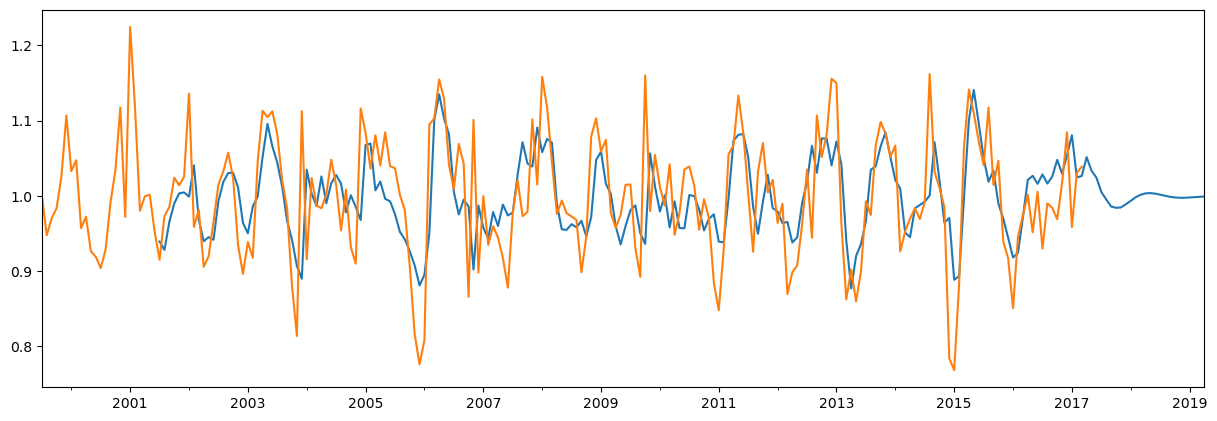

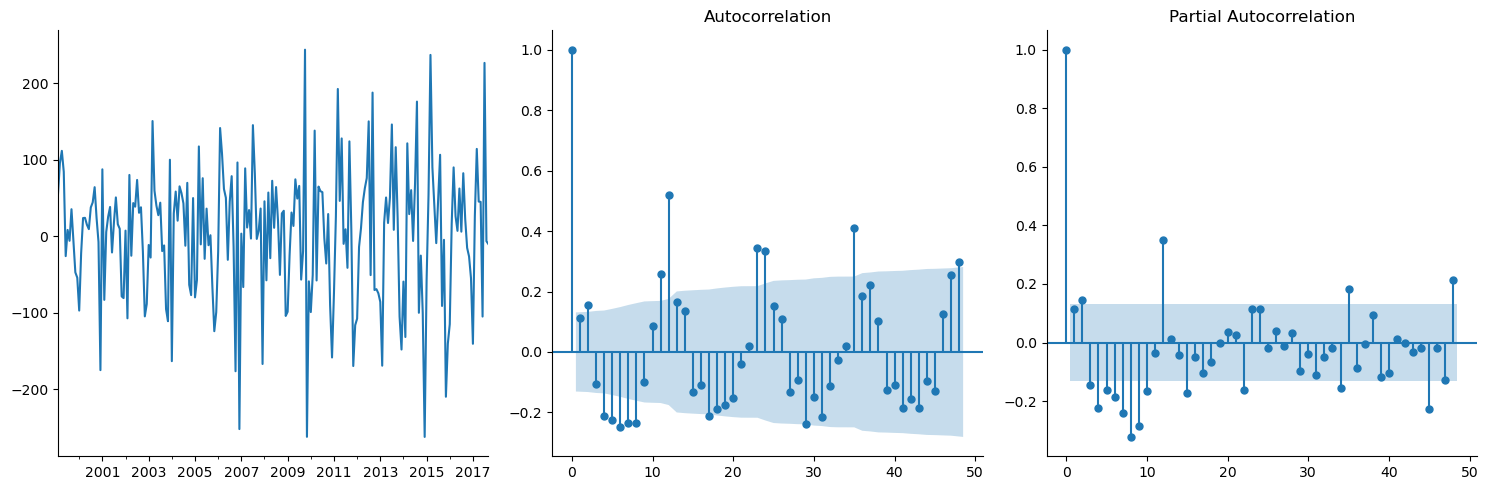

                               SARIMAX Results                                
Dep. Variable:             Production   No. Observations:                  224
Model:               SARIMAX(3, 0, 2)   Log Likelihood               -1271.778
Date:                Sat, 10 Oct 2020   AIC                           2557.555
Time:                        00:58:34   BIC                           2581.437
Sample:                    02-01-1999   HQIC                          2567.195
                         - 09-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3124      0.253      1.236      0.216      -0.183       0.808
ar.L1          1.3590      0.101     13.487      0.000       1.161       1.556
ar.L2         -0.3982      0.136     -2.928      0.0

/usr/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



Figure(1500x500)


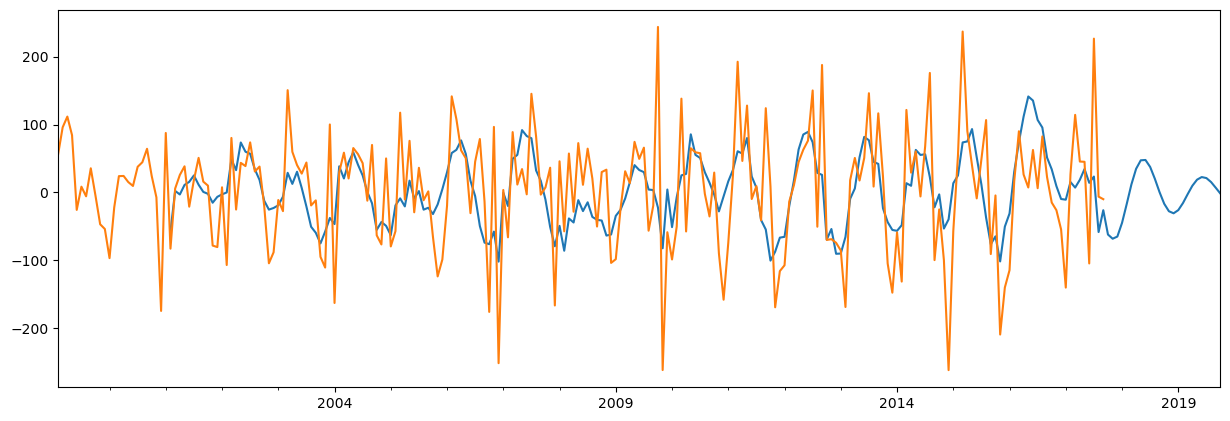

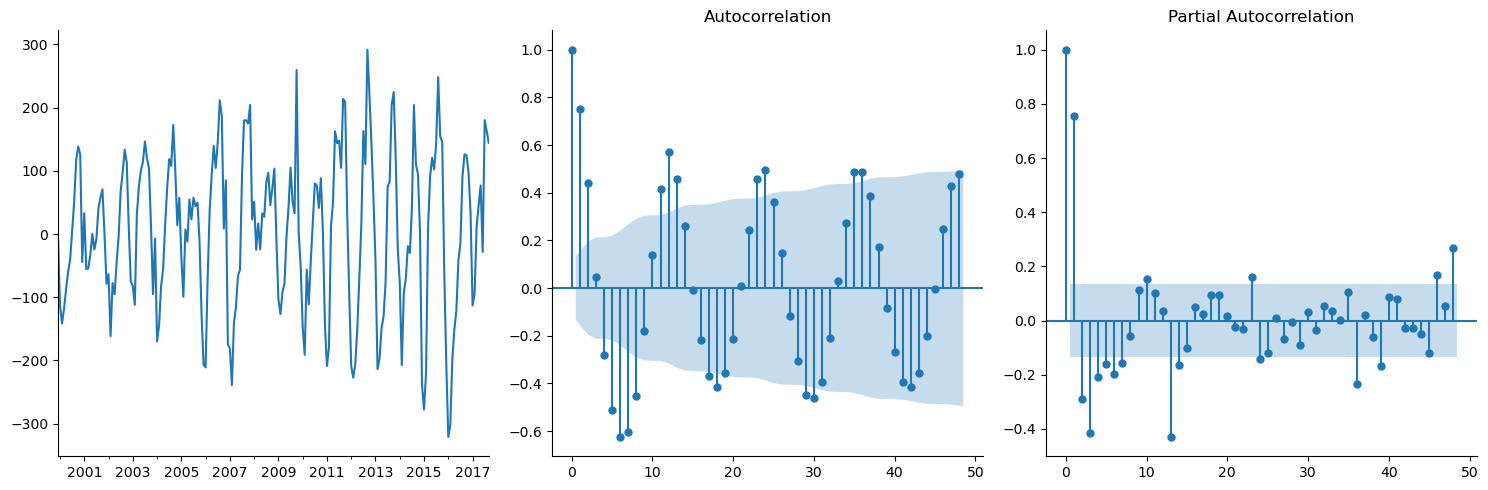

                               SARIMAX Results                                
Dep. Variable:             Production   No. Observations:                  214
Model:               SARIMAX(3, 0, 2)   Log Likelihood               -1201.994
Date:                Sat, 10 Oct 2020   AIC                           2417.987
Time:                        00:58:34   BIC                           2441.549
Sample:                    12-01-1999   HQIC                          2427.508
                         - 09-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.5869      1.624      0.977      0.329      -1.596       4.770
ar.L1          1.2465      0.348      3.583      0.000       0.565       1.928
ar.L2         -0.1892      0.566     -0.334      0.7

/usr/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Figure(1500x500)


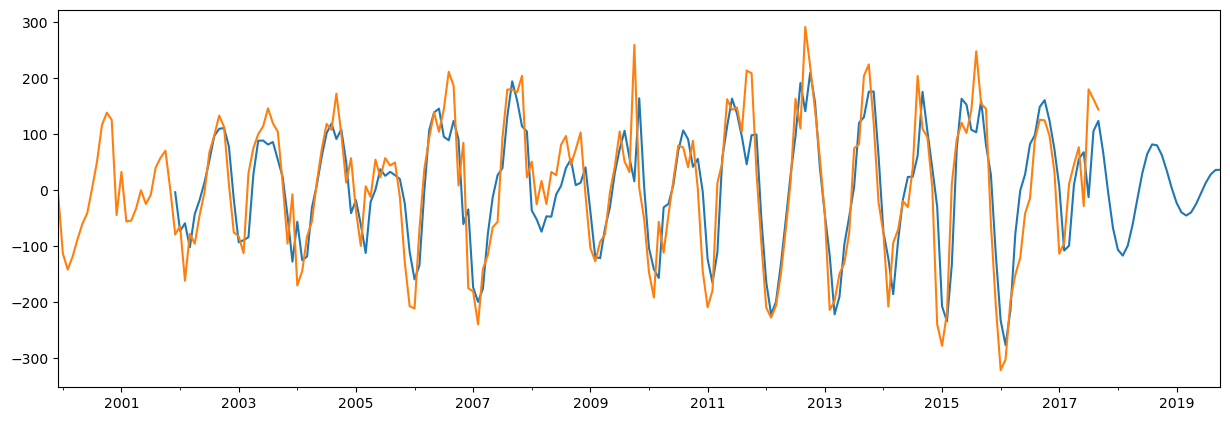

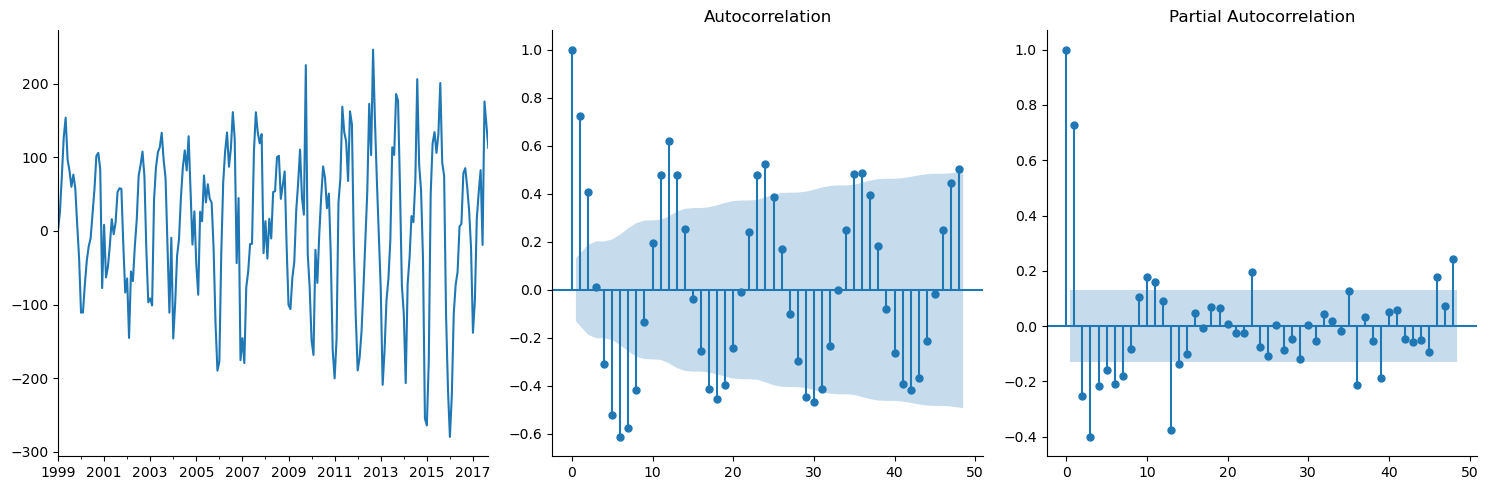

                               SARIMAX Results                                
Dep. Variable:             Production   No. Observations:                  225
Model:               SARIMAX(3, 0, 2)   Log Likelihood               -1234.959
Date:                Sat, 10 Oct 2020   AIC                           2483.919
Time:                        00:58:35   BIC                           2507.831
Sample:                    01-01-1999   HQIC                          2493.570
                         - 09-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.9981      1.101      0.906      0.365      -1.160       3.156
ar.L1          2.2583      0.067     33.783      0.000       2.127       2.389
ar.L2         -1.9110      0.114    -16.729      0.0

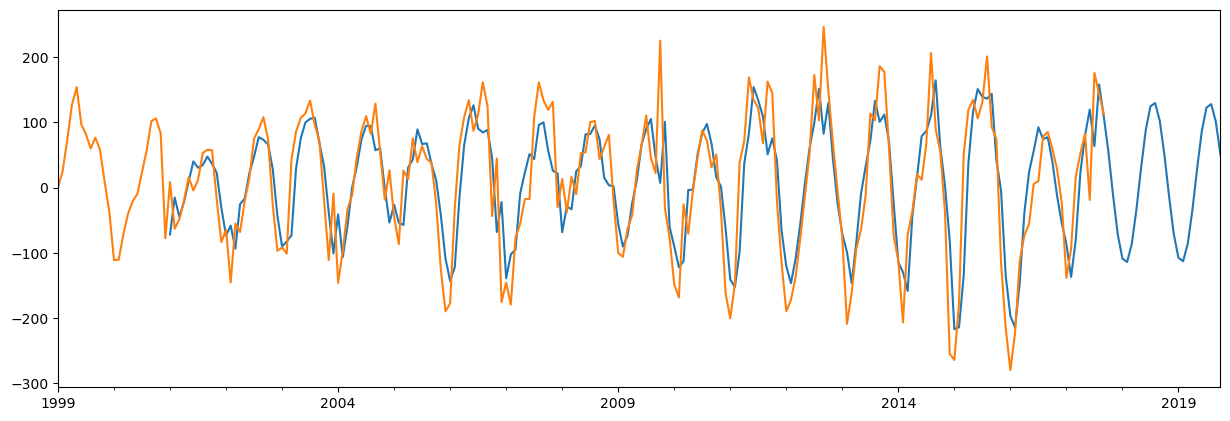

In [72]:

for dt in DATASET:

    # fit SARIMA monthly based on helper plots
    sar = sm.tsa.statespace.SARIMAX(dt, 
                                    order=(3,0,2),  
                                    trend='c').fit()

    print(sar.plot_diagnostics())
    plots(dt, lags=48)
    print(sar.summary())
    res = sar.predict(start = 0 , end= len(dt), dynamic=False)
    res.plot()
    dt.plot()
    
    print("MAPE = {}".format(MAPE(dt, res[:-1])))
    print("MSE = {}".format(mse(dt, res[:-1])))

# ARIMA

/usr/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Figure(1500x500)


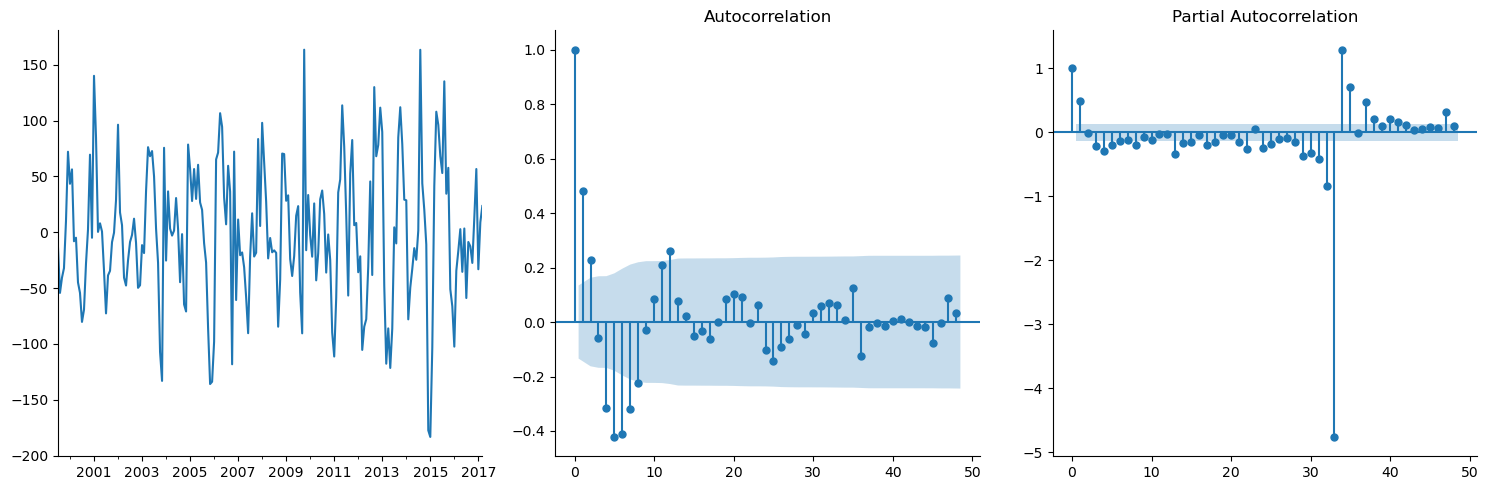

                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                  213
Model:               SARIMAX(3, 1, 2)   Log Likelihood               -1149.116
Date:                Sat, 10 Oct 2020   AIC                           2312.231
Time:                        00:38:13   BIC                           2335.727
Sample:                    07-01-1999   HQIC                          2321.728
                         - 03-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0090      0.116      0.078      0.938      -0.219       0.237
ar.L1         -0.4980      0.076     -6.594      0.000      -0.646      -0.350
ar.L2          0.4730      0.073      6.454      0.0

/usr/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Figure(1500x500)


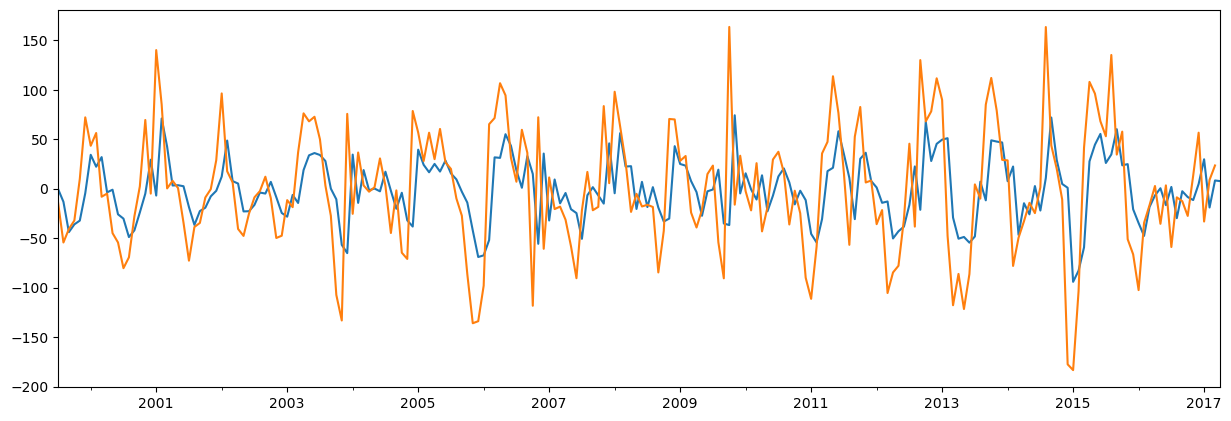

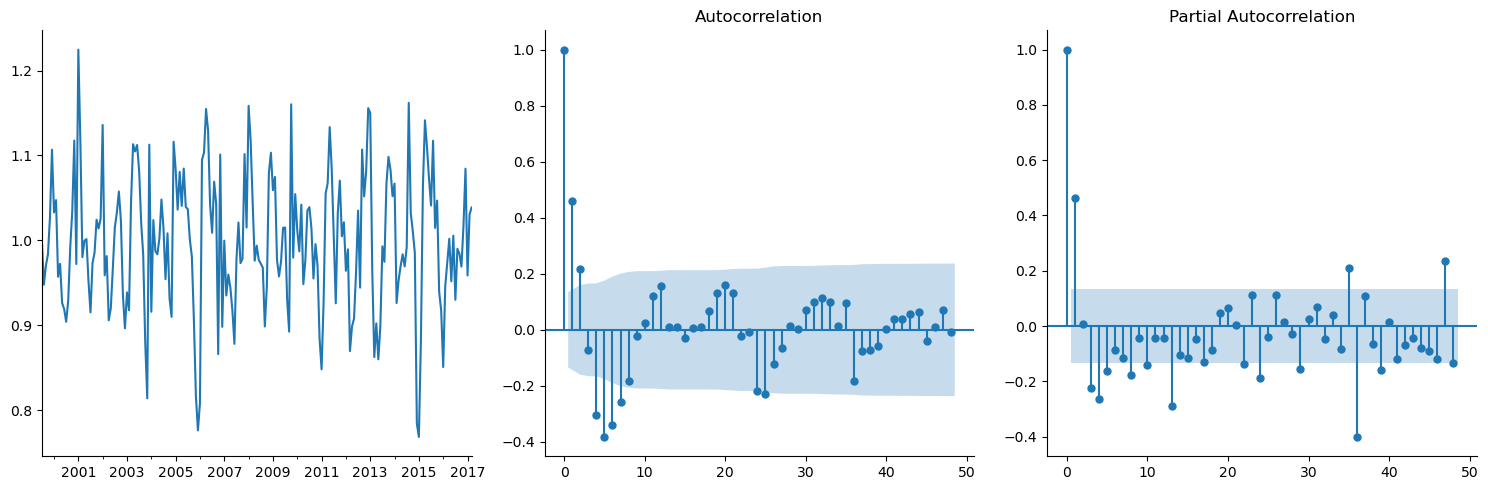

                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                  213
Model:               SARIMAX(3, 1, 2)   Log Likelihood                 257.762
Date:                Sat, 10 Oct 2020   AIC                           -501.524
Time:                        00:38:13   BIC                           -478.027
Sample:                    07-01-1999   HQIC                          -492.027
                         - 03-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -3.018e-05      0.000     -0.172      0.863      -0.000       0.000
ar.L1         -0.3888      0.686     -0.567      0.571      -1.733       0.956
ar.L2          0.4097      0.317      1.294      0.1

/usr/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Figure(1500x500)


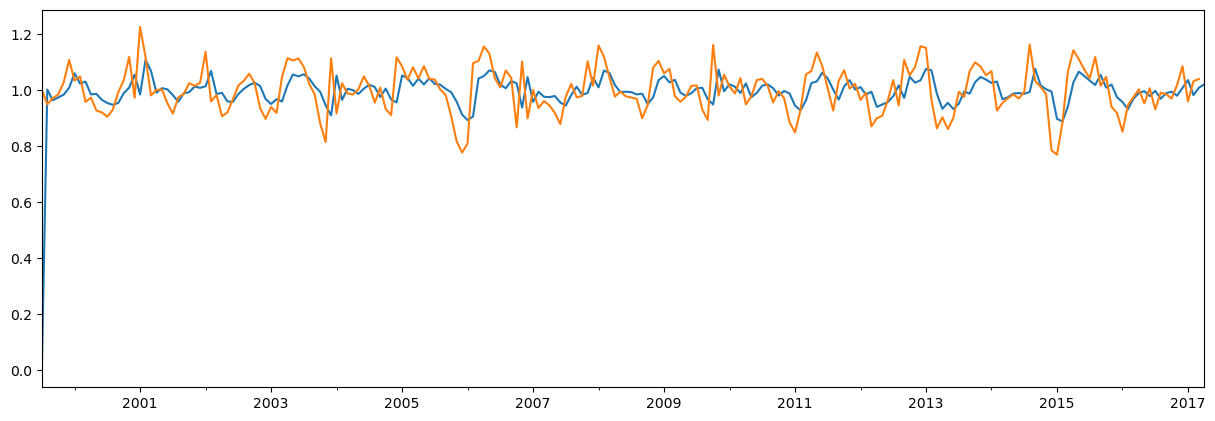

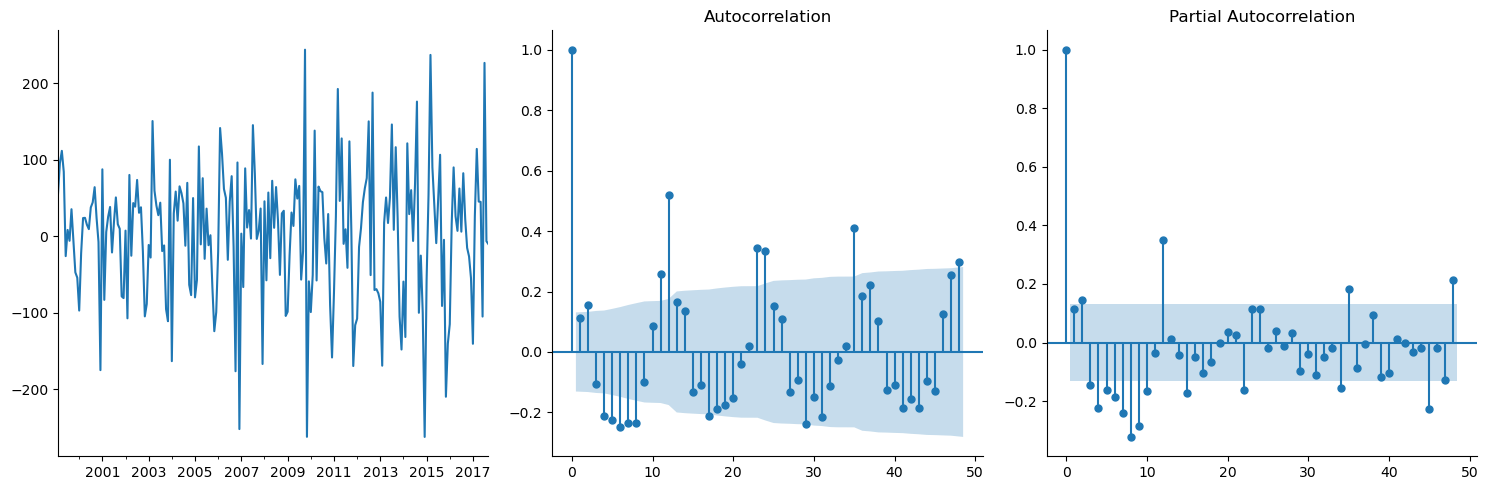

                               SARIMAX Results                                
Dep. Variable:             Production   No. Observations:                  224
Model:               SARIMAX(3, 1, 2)   Log Likelihood               -1306.244
Date:                Sat, 10 Oct 2020   AIC                           2626.488
Time:                        00:38:14   BIC                           2650.338
Sample:                    02-01-1999   HQIC                          2636.116
                         - 09-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0373      0.165     -0.226      0.821      -0.361       0.286
ar.L1         -0.8708      0.065    -13.302      0.000      -0.999      -0.742
ar.L2          0.2534      0.095      2.660      0.0

/usr/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



Figure(1500x500)


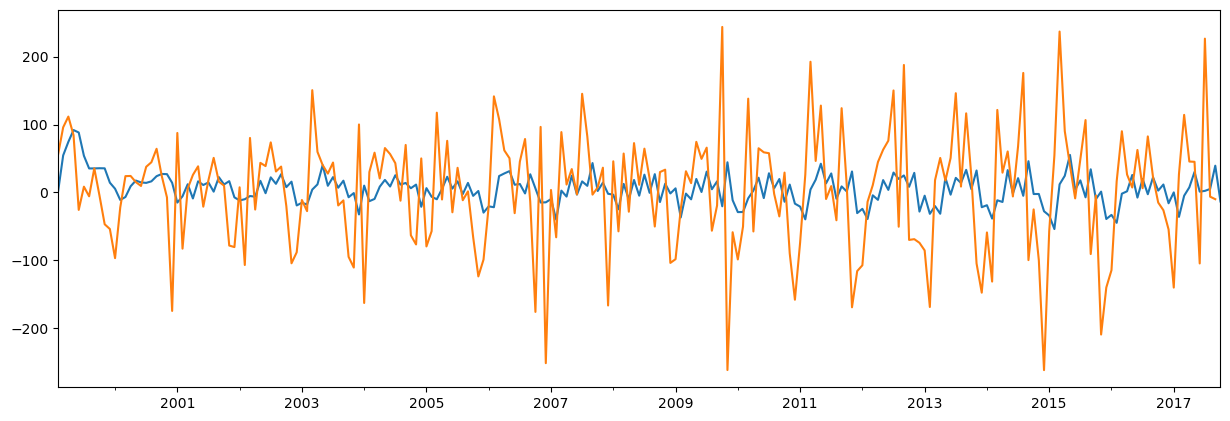

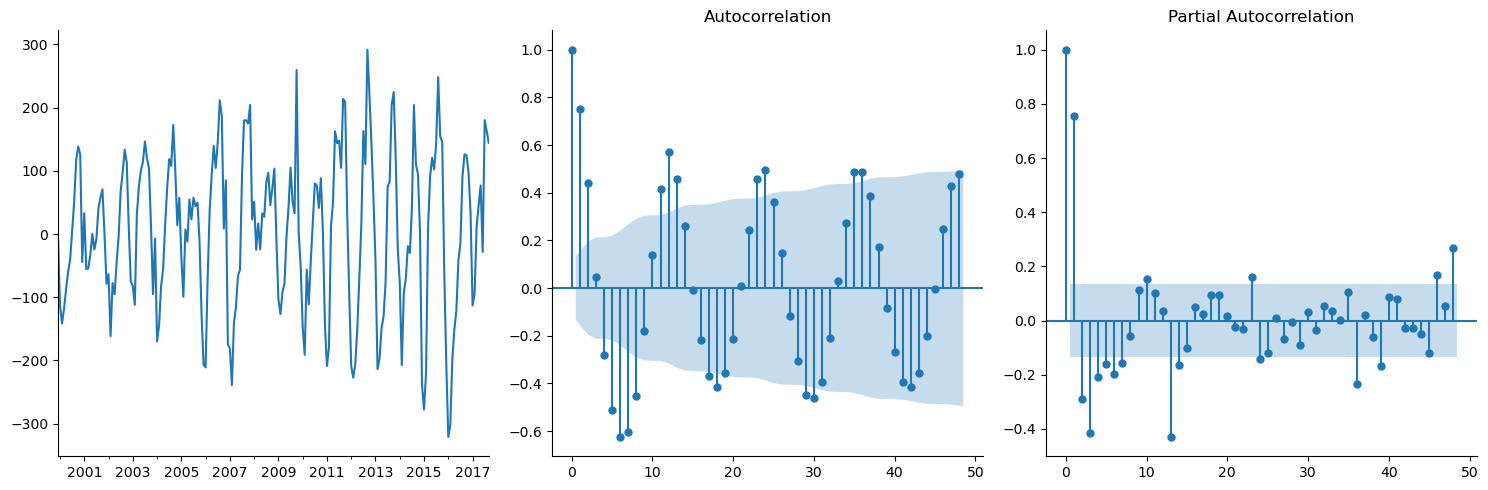

                               SARIMAX Results                                
Dep. Variable:             Production   No. Observations:                  214
Model:               SARIMAX(3, 1, 2)   Log Likelihood               -1199.406
Date:                Sat, 10 Oct 2020   AIC                           2412.812
Time:                        00:38:15   BIC                           2436.341
Sample:                    12-01-1999   HQIC                          2422.321
                         - 09-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0140      0.022     -0.643      0.520      -0.057       0.029
ar.L1          1.3798      0.096     14.365      0.000       1.191       1.568
ar.L2         -0.4105      0.133     -3.091      0.0

/usr/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



Figure(1500x500)


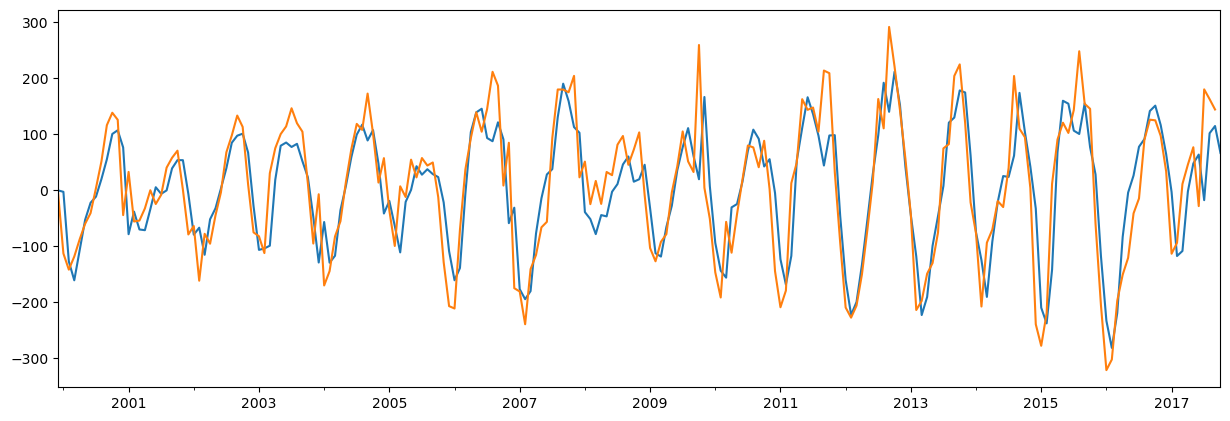

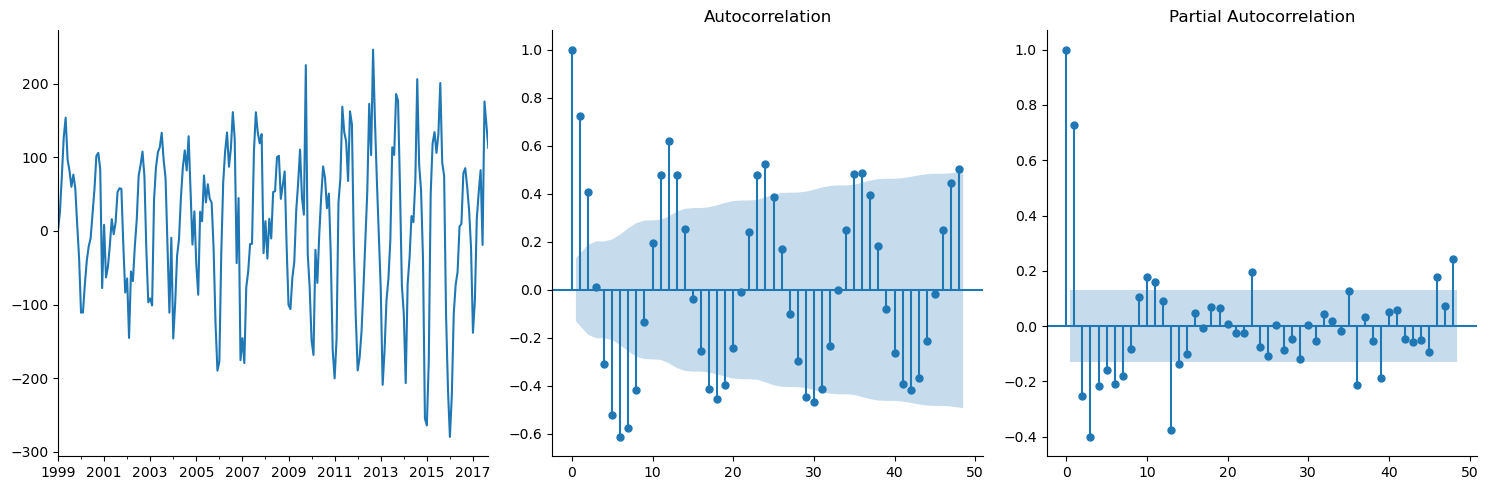

                               SARIMAX Results                                
Dep. Variable:             Production   No. Observations:                  225
Model:               SARIMAX(3, 1, 2)   Log Likelihood               -1235.868
Date:                Sat, 10 Oct 2020   AIC                           2485.737
Time:                        00:38:16   BIC                           2509.618
Sample:                    01-01-1999   HQIC                          2495.376
                         - 09-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0237      0.017     -1.378      0.168      -0.057       0.010
ar.L1          1.3492      0.093     14.511      0.000       1.167       1.531
ar.L2         -0.3838      0.126     -3.043      0.0

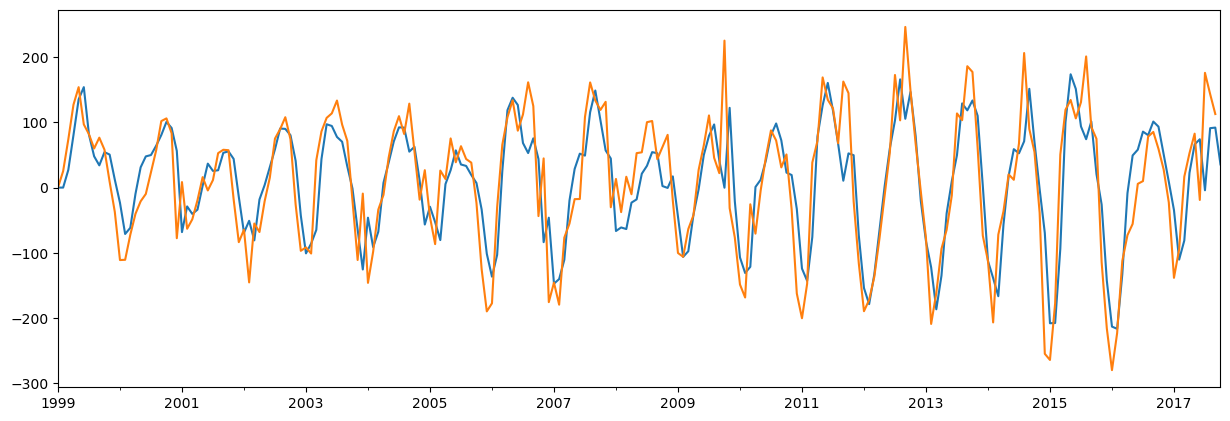

In [52]:


for dt in DATASET:

    # fit SARIMA monthly based on helper plots
    sar = sm.tsa.statespace.SARIMAX(dt, 
                                    order=(3,1,2),  
                                    trend='c').fit()

    print(sar.plot_diagnostics())
    plots(dt, lags=48)
    print(sar.summary())
    res = sar.predict(start = 0 , end= len(dt), dynamic=False)
    res.plot()
    dt.plot()
    
    print("MSE = {}".format(mse(dt, res[:-1])))
    print("MAPE = {}".format(MAPE(dt, res[:-1])))


# ML modelling

In [54]:
#
# main source: https://machinelearningmastery.com/xgboost-for-time-series-forecasting/
#
# doesn`t complete
# forecast monthly births with xgboost

# from numpy import asarray
# from pandas import read_csv
# from pandas import DataFrame
# from pandas import concat
# from sklearn.metrics import mean_absolute_error
# from xgboost import XGBRegressor
# from matplotlib import pyplot

# # transform a time series dataset into a supervised learning dataset
# def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
#     n_vars = 1
#     df = DataFrame(data)
#     cols = list()
#     # input sequence (t-n, ... t-1)
#     for i in range(n_in, 0, -1):
#         cols.append(df.shift(i))
#     # forecast sequence (t, t+1, ... t+n)
#     for i in range(0, n_out):
#         cols.append(df.shift(-i))
#     # put it all together
#     agg = concat(cols, axis=1)
#     # drop rows with NaN values
#     if dropnan:
#         agg.dropna(inplace=True)
#     return agg.values

# # fit an xgboost model and make a one step prediction
# def xgboost_forecast(train, testX):
#     # transform list into array
#     train = asarray(train)
#     # split into input and output columns
#     trainX, trainy = train[:, :-1], train[:, -1]
#     # fit model
#     model = XGBRegressor(max_depth=4, objective='reg:squarederror', n_estimators=1000)
#     model.fit(trainX, trainy)
#     # make a one-step prediction
#     yhat = model.predict(asarray([testX]), validate_features=True)
#     return yhat[0]

# # walk-forward validation for univariate data
# # def walk_forward_validation(data, n_test):
# #     predictions = list()
# #     # split dataset
# #     train, test = data[:-12], data[-12:]
# #     # seed history with training dataset
# #     history = [x for x in train]
# #     # step over each time-step in the test set
# #     for i in range(len(test)):
# #         # split test row into input and output columns
# #         testX, testy = test[i, :-1], test[i, -1]
# #         # fit model on history and make a prediction
# #         yhat = xgboost_forecast(history, testX)
# #         # store forecast in list of predictions
# #         predictions.append(yhat)
# #         # add actual observation to history for the next loop
# #         history.append(test[i])
# #         # summarize progress
# #         print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
# #     # estimate prediction error
# #     error = mean_absolute_error(test[:, -1], predictions)
# #     return error, test[:, -1], predictions

# # load the dataset
# # series = DATA[1]
# # values = series.values
# # # transform the time series data into supervised learning
# # data = series_to_supervised(values, n_in=6)
# # # evaluate
# # mae, y, yhat = walk_forward_validation(data, 12)

# # print('MAE: %.3f' % mae)
# # # plot expected vs preducted
# # pyplot.plot(y, label='Expected')
# # pyplot.plot(yhat, label='Predicted')
# # pyplot.legend()
# # pyplot.show()
# # #-------------------------------
# predictions = list()
    
# history = [x for x in data]

# for i in range(12):
#     # split test row into input and output columns
#     testX, testy = test[i, :-1], test[i, -1]
#     # fit model on history and make a prediction
#     yhat = xgboost_forecast(history, testX)
#     # store forecast in list of predictions
#     predictions.append(yhat)
#     # add actual observation to history for the next loop
#     history.append(test[i])

# values = series.values
# # transform the time series data into supervised learning
# train = series_to_supervised(values, n_in=6)
# # split into input and output columns
# trainX, trainy = train[:, :-1], train[:, -1]
# # fit model
# model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
# model.fit(trainX, trainy)
# # construct an input for a new preduction
# row = values[-6:].flatten()
# # make a one-step prediction
# # yhat = model.predict(asarray([row]))
# # print('Input: %s, Predicted: %.3f' % (row, yhat[0]))
# plt.plot(predictions)


In [57]:
# trainy.to_list()

NameError: name 'trainy' is not defined

In [ ]:
# series.keys()

In [ ]:
DATA[1].tail
# 

# FB Prophet

In [59]:
from fbprophet.diagnostics import cross_validation

dt = (DATA[1].copy())

train_index = dt.index[:-12]
test_index = dt.index[-12:]
valid_index = dt.index[:-112]

train_val = dt.values[:-12]
test_val = dt.values[-12:]
valid_val = dt.values[:-112]

# office = office.rename(columns={'DatetimeIndex': 'ds', 'Sales': 'y'})

dt_model = Prophet(daily_seasonality=True,
                   seasonality_mode='additive')
dt_model.add_seasonality(name='monthly', period=4, fourier_order=5)

res_model = Prophet(daily_seasonality=True,
                   seasonality_mode='additive')
res_model.add_seasonality(name='monthly', period=4, fourier_order=5)

validate = pd.DataFrame()
validate["ds"] = valid_index
validate["y"] = valid_val
validate
validate["floor"] = validate['y'].min()
validate["cap"] = validate["y"].max() + (validate['y'].max() * .2)

dt_model.fit(validate)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


<AxesSubplot:xlabel='ds', ylabel='y'>

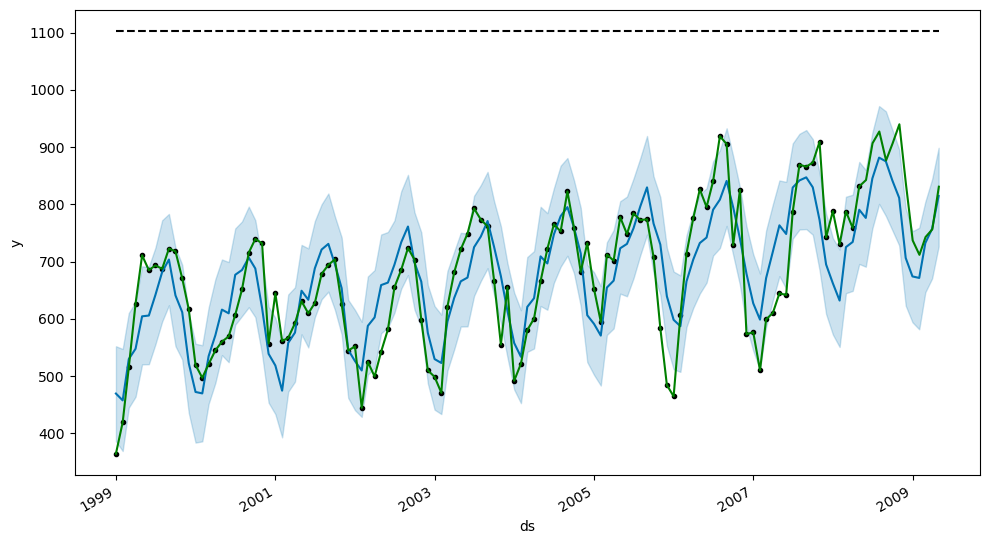

In [60]:
future = dt_model.make_future_dataframe(periods=12, include_history=True, freq="m")
future['floor'] = validate['y'].min()
future['cap'] = validate['y'].max() + (validate['y'].max() *0.2)

forecast = dt_model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

fig1 = dt_model.plot(forecast)
DATA[1][:-100].plot(color='g')

#### On the validation data (first 11 years) the model shows very good results. what about a full dataset?

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


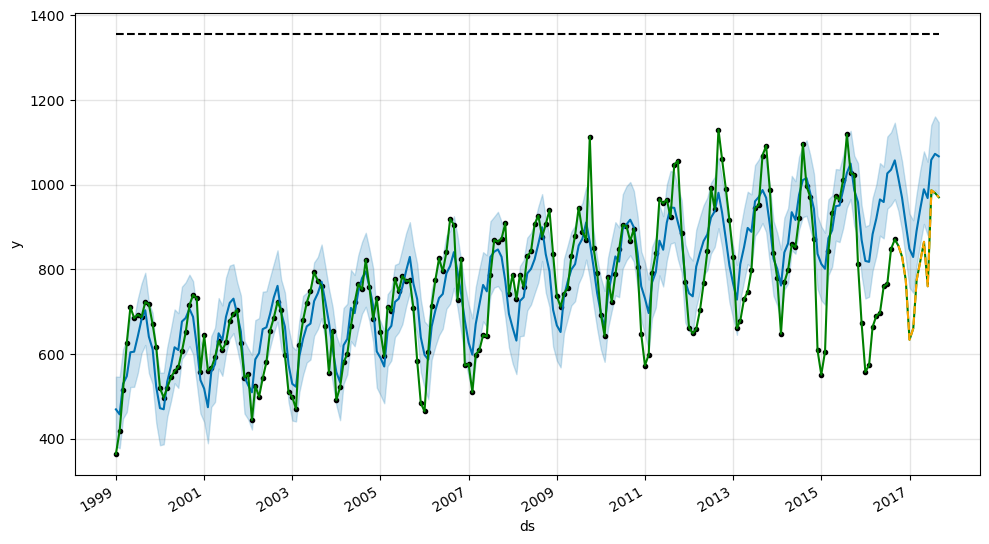

In [61]:
train = pd.DataFrame()
train["ds"] = train_index
train["y"] = train_val
train
train["floor"] = train['y'].min()
train["cap"] = train["y"].max() + (train['y'].max() * .2)

res_model.fit(train)

future = res_model.make_future_dataframe(periods=12, include_history=True, freq="m")
future['floor'] = train['y'].min()
future['cap'] = train['y'].max() + (train['y'].max() *0.2)

forecast = dt_model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

fig1 = res_model.plot(forecast)
DATA[1].plot(color='g')
plt.grid()
# plt.plot(time[:-12], train, 'b--', label="train")
plt.plot(test_index, test_val, color='orange', linestyle="--", label="test")

#### Not so good, but still beautiful. what about metrics?


Figure(900x1200)


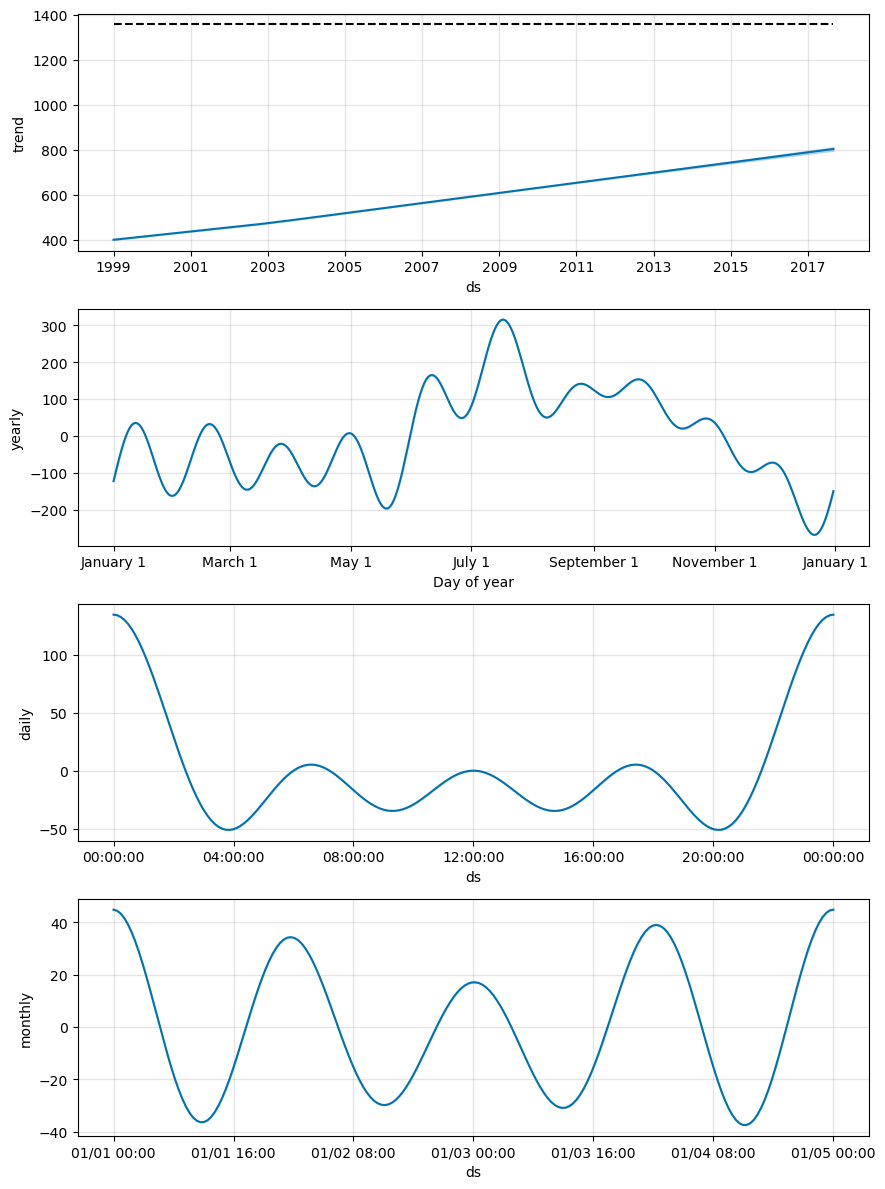

In [62]:
print(res_model.plot_components(forecast))

In [63]:
forecast

ds       trend        cap  yhat_lower   yhat_upper  trend_lower  \
0   1999-01-01  398.851310  1356.2292  381.937225   546.680727   398.851310   
1   1999-02-01  400.403140  1356.2292  377.436572   546.146149   400.403140   
2   1999-03-01  401.804793  1356.2292  447.811123   611.219880   401.804793   
3   1999-04-01  403.356624  1356.2292  462.977258   633.833108   403.356624   
4   1999-05-01  404.858395  1356.2292  522.048512   688.960073   404.858395   
..         ...         ...        ...         ...          ...          ...   
220 2017-04-30  794.919704  1356.2292  907.364548  1078.762936   787.274876   
221 2017-05-31  796.833647  1356.2292  880.838822  1054.332227   789.114551   
222 2017-06-30  798.685850  1356.2292  972.946878  1140.905134   790.867256   
223 2017-07-31  800.599793  1356.2292  987.606318  1161.328118   792.641359   
224 2017-08-31  802.513736  1356.2292  976.959364  1147.411620   794.449340   

     trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0     398.851310       70.449036             70.449036             70.449036   
1     400.403140       56.962034             56.962034             56.962034   
2     401.804793      127.771097            127.771097            127.771097   
3     403.356624      144.177575            144.177575            144.177575   
4     404.858395      199.362484            199.362484            199.362484   
..           ...             ...                   ...                   ...   
220   802.714589      194.323552            194.323552            194.323552   
221   804.690589      171.612675            171.612675            171.612675   
222   806.602421      259.923152            259.923152            259.923152   
223   808.599771      272.330958            272.330958            272.330958   
224   810.594252      264.553913            264.553913            264.553913   

     ...    monthly  monthly_lower  monthly_upper      yearly  yearly_lower  \
0    ...  37.900739      37.900739      37.900739 -108.537211   -108.537211   
1    ...  46.659398      46.659398      46.659398 -130.782872   -130.782872   
2    ...  46.659398      46.659398      46.659398  -59.973809    -59.973809   
3    ...  32.314813      32.314813      32.314813  -29.222747    -29.222747   
4    ...  37.900739      37.900739      37.900739   20.376237     20.376237   
..   ...        ...            ...            ...         ...           ...   
220  ...  32.314813      32.314813      32.314813   20.923230     20.923230   
221  ...  24.210557      24.210557      24.210557    6.316610      6.316610   
222  ...  46.659398      46.659398      46.659398   72.178246     72.178246   
223  ...  32.314813      32.314813      32.314813   98.930637     98.930637   
224  ...  24.210557      24.210557      24.210557   99.257848     99.257848   

     yearly_upper  multiplicative_terms  multiplicative_terms_lower  \
0     -108.537211                   0.0                         0.0   
1     -130.782872                   0.0                         0.0   
2      -59.973809                   0.0                         0.0   
3      -29.222747                   0.0                         0.0   
4       20.376237                   0.0                         0.0   
..            ...                   ...                         ...   
220     20.923230                   0.0                         0.0   
221      6.316610                   0.0                         0.0   
222     72.178246                   0.0                         0.0   
223     98.930637                   0.0                         0.0   
224     99.257848                   0.0                         0.0   

     multiplicative_terms_upper         yhat  
0                           0.0   469.300346  
1                           0.0   457.365174  
2                           0.0   529.575890  
3                           0.0   547.534198  
4                           0.0   604.220879  
..                

In [64]:
res = cross_validation(model=res_model, horizon="365 days")

INFO:fbprophet:Making 28 forecasts with cutoffs between 2002-03-06 12:00:00 and 2015-09-02 00:00:00


In [65]:
df_p = performance_metrics(res)
df_p.head()

horizon           mse        rmse        mae      mape  coverage
0 56 days 12:00:00   7656.993593   87.504249  74.747485  0.096284  0.575758
1 57 days 00:00:00   7786.392063   88.240535  75.967025  0.099068  0.545455
2 57 days 12:00:00   7678.532843   87.627238  75.777241  0.096370  0.530303
3 58 days 00:00:00   9153.584500   95.674367  82.380013  0.105117  0.477273
4 58 days 12:00:00  10287.512542  101.427376  88.748396  0.112550  0.446970

# Deep learning approaches

nothing better proposed approach

Epoch 1/200
4/4 - 0s - loss: 0.2897 - val_loss: 0.3842
Epoch 2/200
4/4 - 0s - loss: 0.2890 - val_loss: 0.3842
Epoch 3/200
4/4 - 0s - loss: 0.2870 - val_loss: 0.3811
Epoch 4/200
4/4 - 0s - loss: 0.2710 - val_loss: 0.3445
Epoch 5/200
4/4 - 0s - loss: 0.2472 - val_loss: 0.2943
Epoch 6/200
4/4 - 0s - loss: 0.2040 - val_loss: 0.2429
Epoch 7/200
4/4 - 0s - loss: 0.1648 - val_loss: 0.1934
Epoch 8/200
4/4 - 0s - loss: 0.1251 - val_loss: 0.1478
Epoch 9/200
4/4 - 0s - loss: 0.0924 - val_loss: 0.1079
Epoch 10/200
4/4 - 0s - loss: 0.0650 - val_loss: 0.0746
Epoch 11/200
4/4 - 0s - loss: 0.0466 - val_loss: 0.0490
Epoch 12/200
4/4 - 0s - loss: 0.0345 - val_loss: 0.0312
Epoch 13/200
4/4 - 0s - loss: 0.0303 - val_loss: 0.0202
Epoch 14/200
4/4 - 0s - loss: 0.0273 - val_loss: 0.0144
Epoch 15/200
4/4 - 0s - loss: 0.0241 - val_loss: 0.0119
Epoch 16/200
4/4 - 0s - loss: 0.0242 - val_loss: 0.0113
Epoch 17/200
4/4 - 0s - loss: 0.0277 - val_loss: 0.0119
Epoch 18/200
4/4 - 0s - loss: 0.0241 - val_loss: 0.0130
E

Epoch 147/200
4/4 - 0s - loss: 0.0129 - val_loss: 0.0227
Epoch 148/200
4/4 - 0s - loss: 0.0137 - val_loss: 0.0231
Epoch 149/200
4/4 - 0s - loss: 0.0139 - val_loss: 0.0224
Epoch 150/200
4/4 - 0s - loss: 0.0119 - val_loss: 0.0208
Epoch 151/200
4/4 - 0s - loss: 0.0159 - val_loss: 0.0201
Epoch 152/200
4/4 - 0s - loss: 0.0116 - val_loss: 0.0208
Epoch 153/200
4/4 - 0s - loss: 0.0123 - val_loss: 0.0221
Epoch 154/200
4/4 - 0s - loss: 0.0144 - val_loss: 0.0236
Epoch 155/200
4/4 - 0s - loss: 0.0128 - val_loss: 0.0241
Epoch 156/200
4/4 - 0s - loss: 0.0130 - val_loss: 0.0232
Epoch 157/200
4/4 - 0s - loss: 0.0140 - val_loss: 0.0224
Epoch 158/200
4/4 - 0s - loss: 0.0140 - val_loss: 0.0224
Epoch 159/200
4/4 - 0s - loss: 0.0118 - val_loss: 0.0225
Epoch 160/200
4/4 - 0s - loss: 0.0136 - val_loss: 0.0220
Epoch 161/200
4/4 - 0s - loss: 0.0129 - val_loss: 0.0216
Epoch 162/200
4/4 - 0s - loss: 0.0130 - val_loss: 0.0219
Epoch 163/200
4/4 - 0s - loss: 0.0122 - val_loss: 0.0228
Epoch 164/200
4/4 - 0s - loss: 

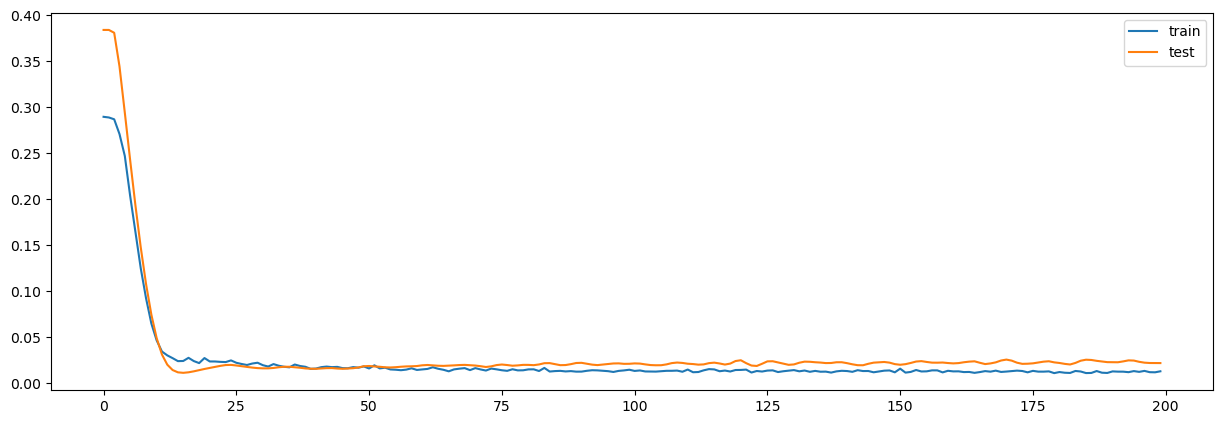

In [66]:
values = np.concatenate((DATA[0].values, DATA[1].values.reshape((-1, 1))), axis=1)
scaler = MinMaxScaler(feature_range=(0, 1))
values = scaler.fit_transform(values)

VALIDATION_SHIFT = 12
EPOCHS = 200

train = values[:-VALIDATION_SHIFT, :]
test = values[-VALIDATION_SHIFT:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

optimizer = Adagrad(0.01)

# reshape input to be 3D [samples, features, timesteps]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

model = Sequential()
model.add(LSTM(20, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1, activation='relu'))
# model.compile(loss='mae', optimizer=optimizer)
model.compile(loss='mean_squared_error', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, 
                    epochs=EPOCHS, batch_size=64, 
                    validation_data=(test_X, test_y), 
                    verbose=2, shuffle=False)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# make a prediction
yhat = model.predict(test_X)
yhat[yhat<0] = 0
yhat_train = model.predict(train_X)
yhat_train[yhat_train<0] = 0

test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
train_X = train_X.reshape((train_X.shape[0], train_X.shape[2]))



Test RMSE: 113.474
Actual data:  [855.692 829.251 774.394 633.767 660.446 774.698 820.077 865.067 760.05
 986.796 980.377 970.19 ]
Forecast:  [902.49400329 836.99823999 754.40469491 570.74247632 569.26372456
 613.94122184 644.30638095 689.55078329 730.33436669 821.41660338
 858.6503927  875.40332416]


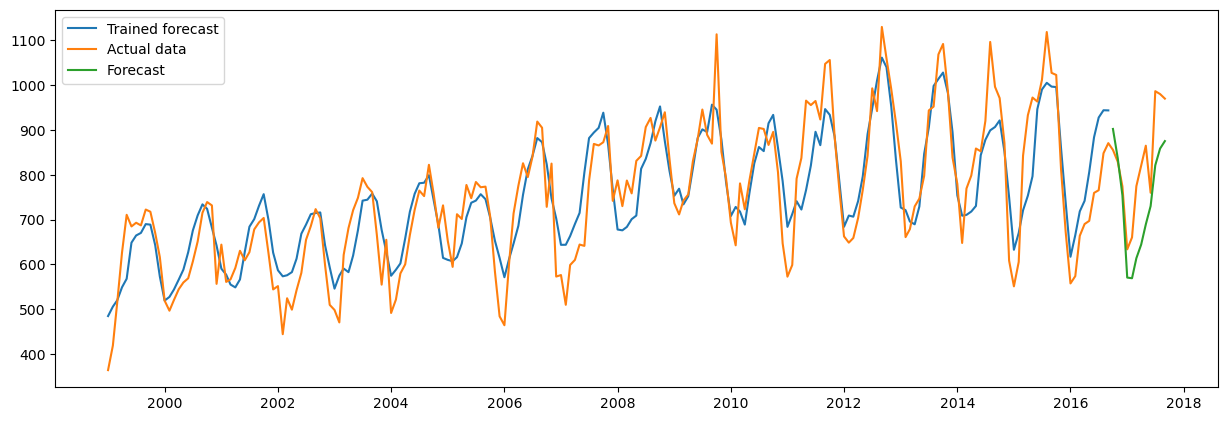

In [67]:
# invert scaling for training
inv_yhat_train = np.concatenate((train_X, yhat_train), axis=1)
inv_yhat_train = scaler.inverse_transform(inv_yhat_train)
inv_yhat_train = inv_yhat_train[:,-1]


# invert scaling for forecast
inv_yhat = np.concatenate((test_X, yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_X, test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]


# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
print("Actual data: ", inv_y)
print("Forecast: ",inv_yhat)

plt.plot(pd.Series(inv_yhat_train, index=DATA[1].index[:-VALIDATION_SHIFT]), label="Trained forecast")
plt.plot(DATA[1], label="Actual data")
plt.plot(pd.Series(inv_yhat, index=DATA[1].index[-VALIDATION_SHIFT:]), label="Forecast")
plt.legend()

Epoch 1/200
4/4 - 0s - loss: 0.1174 - val_loss: 0.0438
Epoch 2/200
4/4 - 0s - loss: 0.0301 - val_loss: 0.0313
Epoch 3/200
4/4 - 0s - loss: 0.0275 - val_loss: 0.0296
Epoch 4/200
4/4 - 0s - loss: 0.0266 - val_loss: 0.0290
Epoch 5/200
4/4 - 0s - loss: 0.0258 - val_loss: 0.0289
Epoch 6/200
4/4 - 0s - loss: 0.0251 - val_loss: 0.0286
Epoch 7/200
4/4 - 0s - loss: 0.0244 - val_loss: 0.0281
Epoch 8/200
4/4 - 0s - loss: 0.0239 - val_loss: 0.0276
Epoch 9/200
4/4 - 0s - loss: 0.0234 - val_loss: 0.0271
Epoch 10/200
4/4 - 0s - loss: 0.0229 - val_loss: 0.0269
Epoch 11/200
4/4 - 0s - loss: 0.0224 - val_loss: 0.0264
Epoch 12/200
4/4 - 0s - loss: 0.0220 - val_loss: 0.0261
Epoch 13/200
4/4 - 0s - loss: 0.0216 - val_loss: 0.0258
Epoch 14/200
4/4 - 0s - loss: 0.0212 - val_loss: 0.0253
Epoch 15/200
4/4 - 0s - loss: 0.0208 - val_loss: 0.0250
Epoch 16/200
4/4 - 0s - loss: 0.0204 - val_loss: 0.0248
Epoch 17/200
4/4 - 0s - loss: 0.0201 - val_loss: 0.0245
Epoch 18/200
4/4 - 0s - loss: 0.0197 - val_loss: 0.0243
E

Epoch 147/200
4/4 - 0s - loss: 0.0095 - val_loss: 0.0199
Epoch 148/200
4/4 - 0s - loss: 0.0095 - val_loss: 0.0198
Epoch 149/200
4/4 - 0s - loss: 0.0094 - val_loss: 0.0199
Epoch 150/200
4/4 - 0s - loss: 0.0094 - val_loss: 0.0198
Epoch 151/200
4/4 - 0s - loss: 0.0094 - val_loss: 0.0198
Epoch 152/200
4/4 - 0s - loss: 0.0094 - val_loss: 0.0198
Epoch 153/200
4/4 - 0s - loss: 0.0094 - val_loss: 0.0198
Epoch 154/200
4/4 - 0s - loss: 0.0094 - val_loss: 0.0197
Epoch 155/200
4/4 - 0s - loss: 0.0093 - val_loss: 0.0198
Epoch 156/200
4/4 - 0s - loss: 0.0093 - val_loss: 0.0197
Epoch 157/200
4/4 - 0s - loss: 0.0093 - val_loss: 0.0197
Epoch 158/200
4/4 - 0s - loss: 0.0093 - val_loss: 0.0197
Epoch 159/200
4/4 - 0s - loss: 0.0093 - val_loss: 0.0197
Epoch 160/200
4/4 - 0s - loss: 0.0093 - val_loss: 0.0197
Epoch 161/200
4/4 - 0s - loss: 0.0093 - val_loss: 0.0197
Epoch 162/200
4/4 - 0s - loss: 0.0093 - val_loss: 0.0196
Epoch 163/200
4/4 - 0s - loss: 0.0092 - val_loss: 0.0197
Epoch 164/200
4/4 - 0s - loss: 

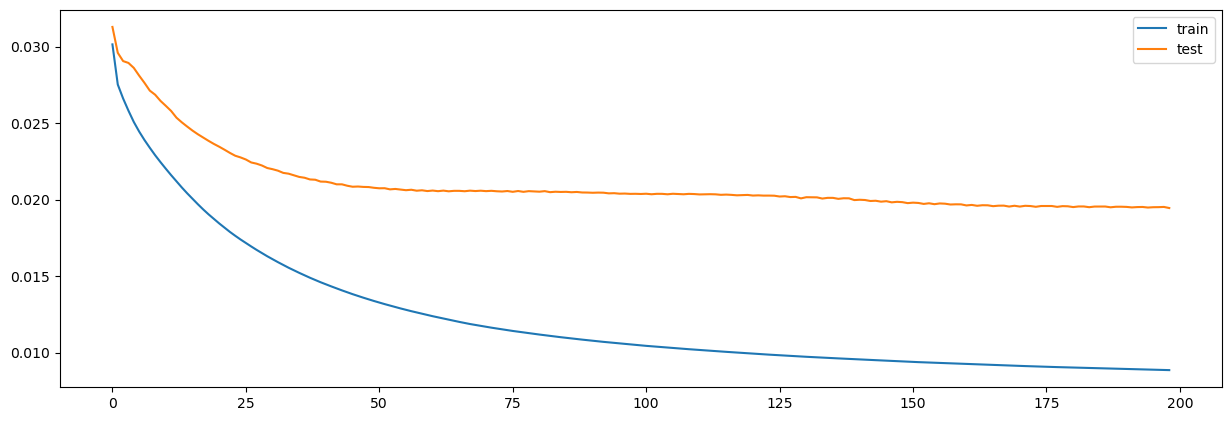

In [68]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))

model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=3, activation='relu', 
                     input_shape=(train_X.shape[1], train_X.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer=optimizer)

history = model_cnn.fit(train_X, train_y, 
                        epochs=EPOCHS, batch_size=64, 
                        validation_data=(test_X, test_y), 
                        verbose=2, shuffle=False)

# plot history
plt.plot(history.history['loss'][1:], label='train')
plt.plot(history.history['val_loss'][1:], label='test')
plt.legend()
plt.show()

# make a prediction
yhat = model_cnn.predict(test_X)
yhat[yhat<0] = 0
yhat_train = model_cnn.predict(train_X)
yhat_train[yhat_train<0] = 0

test_X = test_X.reshape((test_X.shape[0], test_X.shape[1]))
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1]))

Test RMSE: 106.821
Actual data:  [855.692 829.251 774.394 633.767 660.446 774.698 820.077 865.067 760.05
 986.796 980.377 970.19 ]
Forecast:  [847.06884624 770.73196247 702.42021076 594.2287323  588.5297076
 618.8908032  651.13780039 698.14848193 744.39294105 839.40301505
 865.16757511 895.39866128]


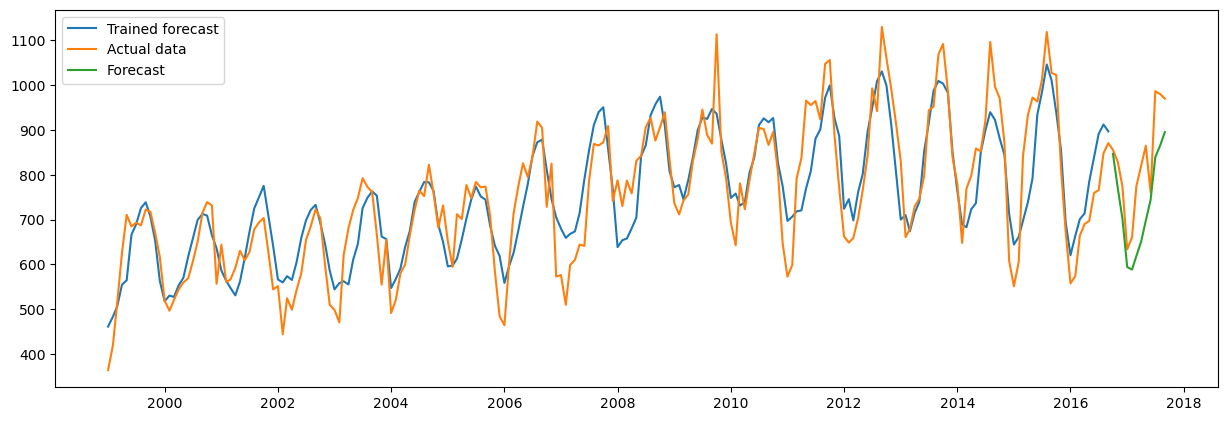

In [69]:
# invert scaling for training
inv_yhat_train = np.concatenate((train_X, yhat_train), axis=1)
inv_yhat_train = scaler.inverse_transform(inv_yhat_train)
inv_yhat_train = inv_yhat_train[:,-1]


# invert scaling for forecast
inv_yhat = np.concatenate((test_X, yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_X, test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]


# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
print("Actual data: ", inv_y)
print("Forecast: ",inv_yhat)

plt.plot(pd.Series(inv_yhat_train, index=DATA[1].index[:-VALIDATION_SHIFT]), label="Trained forecast")
plt.plot(DATA[1], label="Actual data")
plt.plot(pd.Series(inv_yhat, index=DATA[1].index[-VALIDATION_SHIFT:]), label="Forecast")
plt.legend()

# Conclusion & prediction for one year

I tested all models (except ML) and in my opinion, even ARIMA and fbprophet are very good approaches, and ARIMA fit's the model even better then fb, but for long term predictions it is better to use fb.

My series is additive. 

About stationary series - the best way is to use EMA and sub from the data the series. 

Differencing is not very good approach in this case.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


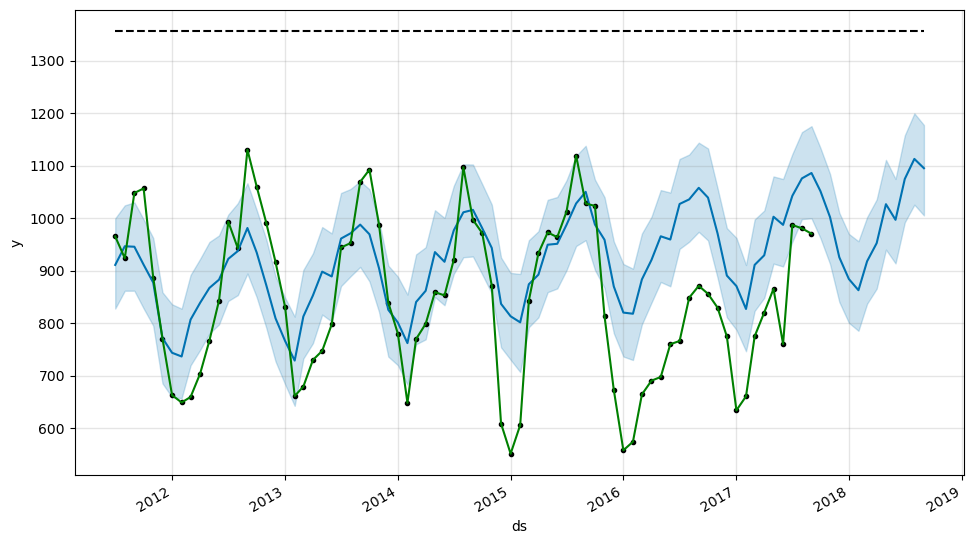

In [70]:
from fbprophet.diagnostics import cross_validation

dt = (DATA[1].copy())[150:]

res_model = Prophet(daily_seasonality=True,
                   seasonality_mode='additive')
res_model.add_seasonality(name='monthly', period=4, fourier_order=5)

train = pd.DataFrame()
train["ds"] = dt.index
train["y"] = dt.values

train["floor"] = train['y'].min()
train["cap"] = train["y"].max() + (train['y'].max() * .2)

res_model.fit(train)

future = res_model.make_future_dataframe(periods=12, include_history=True, freq="m")
future['floor'] = train['y'].min()
future['cap'] = train['y'].max() + (train['y'].max() *0.2)

forecast = dt_model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

fig1 = res_model.plot(forecast)
dt.plot(color='g')
plt.grid()